In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"

warnings.filterwarnings('ignore')

data_dir = 'data'

df = pd.read_csv("./input_df.csv")
df

value   
0                                  반려동물의 종류에 대해서 알고 계신가요?  \
1                                                      네.   
2                                                알고 있습니다.   
3       보통 요즘 현대인들이 많이 키우는 반려동물은 개 고양이 위주로 많이 키우는데 그 외...   
4       저도 기회가 된다면 나중에는 고슴도치 같은 걸 키워보고 싶기도 하고 제 주위에 뱀을...   
...                                                   ...   
176822     아무래도 영상학과고 서로 협업해야 하는 과제가 많기 때문에 그런 경우가 있었는데요.   
176823  보통 선배들과 후배들이 친해지는 경우가 꽤 있고 그런 경우에는 선배가 후배에게 그 ...   
176824  아니면 과제가 많다 적다 아니면 시험은 이런 식으로 내신다 이런 식의 선배들이 도움...   
176825  후배들은 선배가 취업 활동을 진행할 때 그에 다른 도움을 주거나 그~ 그런 식으로 ...   
176826  대학교에는 다양한 장학금 제도가 진행되고 있다고 들었는데 장학금은 꼭 학점이 높은 ...   

                                                    label  
0                                                      네.  
1                                                알고 있습니다.  
2       보통 요즘 현대인들이 많이 키우는 반려동물은 개 고양이 위주로 많이 키우는데 그 외...  
3       저도 기회가 된다면 나중에는 고슴도치 같은 걸 키워보고 싶기도 하고 제 주위에 뱀을...  
4                                        키우는 반려동물이 있으신가요?  
...                                                   ...  
176822  보통 선배들과 후배들이 친해지는 경우가 꽤 있고 그런 경우에는 선배가 후배에게 그 ...  
176823  아니면 과제가 많다 적다 아니면 시험은 이런 식으로 내신다 이런 식의 선배들이 도움...  
176824  후배들은 선배가 취업 활동을 진행할 때 그에 다른 도움을 주거나 그~ 그런 식으로 ...  
176825  대학교에는 다양한 장학금 제도가 진행되고 있다고 들었는데 장학금은 꼭 학점이 높은 ...  
176826                                          그렇지는 않아요.  

[176827 rows x 2 columns]

In [81]:
question = df['value']
answer = df['label']

데이터 전처리

In [82]:
#한글 정규화
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [83]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[10])

'이렇게 동물 반려동물과 같이 사니까 반려동물이 주는 행복감도 있고 또 그 안에서 제가 배울 점도 몇 가지 생기고 책임져야 할 것이 있으니까 조금 더 노력하게 되고 그렇게 되는 거 같습니다.'

In [84]:
from konlpy.tag import Okt

# 형태소 분석기

okt = Okt()

In [85]:
# okt
okt.morphs(normalize(answer[10]))

['연예인', '들', '의', '이색', '반려견', '에', '대해', '서', '어떻게', '아시나요', '?']

In [9]:
# 한글 전처리를 함수화
def clean_text(sentence, tagger):
    sentence = normalize(sentence)
    sentence = tagger.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [10]:
clean_text(question[10], okt)

'이렇게 동물 반려동물 과 같이 사 니까 반려동물 이 주는 행복감 도 있고 또 그 안 에서 제 가 배울 점도 몇 가지 생기 고 책임져야 할 것 이 있으니까 조금 더 노력 하게 되고 그렇게 되는 거 같습니다 .'

In [11]:
clean_text(answer[10], okt)

'연예인 들 의 이색 반려견 에 대해 서 어떻게 아시나요 ?'

In [12]:
len(question), len(answer)

(176827, 176827)

In [13]:
questions = [clean_text(sent, okt) for sent in question.values[:1000]]
answers = [clean_text(sent, okt) for sent in answer.values[:1000]]

In [15]:
len(questions), len(answers)

(1000, 1000)

In [16]:
#단어 사전 생성
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
    
    def index_to_word(self, idx):
        return self.index2word[idx]

In [86]:
print(f'원문: {questions[10]}')
wordvocab = WordVocab()
wordvocab.add_sentence(questions[10])
print('==='*10)
print('단어사전')
print(wordvocab.word2index)

원문: 이렇게 동물 반려동물 과 같이 사 니까 반려동물 이 주는 행복감 도 있고 또 그 안 에서 제 가 배울 점도 몇 가지 생기 고 책임져야 할 것 이 있으니까 조금 더 노력 하게 되고 그렇게 되는 거 같습니다 .
단어사전
{'<SOS>': 0, '<EOS>': 1, '<UKN>': 2, '이렇게': 3, '동물': 4, '반려동물': 5, '과': 6, '같이': 7, '사': 8, '니까': 9, '이': 10, '주는': 11, '행복감': 12, '도': 13, '있고': 14, '또': 15, '그': 16, '안': 17, '에서': 18, '제': 19, '가': 20, '배울': 21, '점도': 22, '몇': 23, '가지': 24, '생기': 25, '고': 26, '책임져야': 27, '할': 28, '것': 29, '있으니까': 30, '조금': 31, '더': 32, '노력': 33, '하게': 34, '되고': 35, '그렇게': 36, '되는': 37, '거': 38, '같습니다': 39, '.': 40}


In [87]:
#전처리 프로세스를 클레스화 - 데이터 로드, 전처리, 사전 생성, 시퀀스 변환
from konlpy.tag import Okt


class QADataset():
    def __init__(self, csv_path, min_length=1, max_length=647):
        data_dir = 'data'
        
        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(csv_path)
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['value']
            tgt = row['label']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.srcs)

In [88]:
MAX_LENGTH = 647

dataset = QADataset('./input_df.csv', min_length=1, max_length=MAX_LENGTH)

In [90]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

보통 요즘 현대인 들 이 많이 키우는 반려동물 은 개 고양이 위주 로 많이 키우는데 그 외 에도 요즘 에 이 이색 적 이 게 침팬지 햄스터 혹은 작은 미니 피그 같은 동물 도 많이 키우고 있 있다고 들었습니다 . <EOS>
저 도 기회 가 된다면 나중 에는 고슴도치 같은 걸 키워 보고 싶기도 하고 제 주위 에 뱀 을 뱀 이나 도마뱀 같은 것 을 키우는 사람 도 많고 현재 는 많은 많이 다양해진 반려동물 을 볼 수 있다고 생각 을 하고 있습니다 . <EOS>


Encoder

In [91]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False, 
                          batch_first=True,
                         )
    def init_weights(self):
        initrange = 1
        self.gru.weight.data.uniform_ = (-initrange, initrange)
        
    def forward(self, x, hidden):
        # (sequence_length, 1)
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden
    
    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [92]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 89168


In [93]:
#encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=32, 
                  embedding_dim=20, 
                  num_layers=1)

In [94]:
# Encoder hidden_state 초기화
encoder.init_hidden(device=device).shape

torch.Size([1, 1, 32])

In [95]:
# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
encoder_out, encoder_hidden = encoder(x[0], torch.zeros_like(encoder.init_hidden(device='cpu')))

print(encoder_out.shape)
print(encoder_hidden.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


Decoder

In [96]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1):
        super(Decoder, self).__init__()
        # 단어사전 개수
        self.num_vocabs = num_vocabs
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)
    
    def init_weights(self):
        initrange = 1
        self.gru.weight.data.uniform_ = (-initrange, initrange)
        self.gru.bias.data.zero_()
        
    def forward(self, x, hidden_state):
        x = self.embedding(x) # (H): 1개의 word에 대한 h
        x = x.view(1, 1, -1) # (1, 1, H) 로 변환
        embedded = F.relu()
        output, hidden = self.gru(embedded, hidden_state)
        output = self.fc(output.squeeze(0)) # (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
        return output, hidden

In [97]:
x = torch.abs(torch.randn(size=(10, 1)).long())
print(x.shape)
# (디코더의 sequence_length, 1)

torch.Size([10, 1])


In [98]:
#임베딩 layer
embedding_dim = 20 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x[0])
# 디코더의 1개 토큰에 대한 임베딩 차원
# (1, embedding_dim)
print(embedded.shape)
embedded = embedded.view(1, 1, -1)
# (1, 1, embedding_dim)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


In [99]:
#GRU layer 입출력
embedding_dim = 20 # 임베딩 차원
hidden_size = 32

gru = nn.GRU(embedding_dim, 
             hidden_size, 
             num_layers=1, 
             bidirectional=False)

decoder_out, decoder_hidden = gru(embedded)

print(decoder_out.shape)
# decoder_out: (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
print(decoder_hidden.shape)
# decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


In [100]:
#출력층
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(decoder_out[0])

print(decoder_out[0].shape)
print(output.shape)
# input : (batch_size, hidden_size)
# output: (batch_size, output dimension(number of vocabs))

torch.Size([1, 32])
torch.Size([1, 89168])


attention이 적용된 Decoder

In [101]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_vocabs)

    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)

        
        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((embedded[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)
                            
        attn = self.attn(attn_in)
        # attn: (1, max_length)
                         
        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)
        
        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)
        
        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)
        
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        
        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)
        
        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [102]:
# 디코더 문장의 길이가 12 단어라고 가정한 경우
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

디코더 1개에 대한 임베딩

In [103]:
embedding_dim = 20
embedding = nn.Embedding(wordvocab.n_words, embedding_dim)

# Decoder의 단어 1개: x[0]를 입력으로 가짐
embedded = embedding(x[0])
print(embedded.shape)
# (1, 20)

embedded = embedded.view(1, 1, -1)
# (1, 1, 20)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


In [104]:
# dropout 적용
dropout = nn.Dropout(0.1)
embedded = dropout(embedded)
embedded.shape

torch.Size([1, 1, 20])

-디코더의 첫 번째 단어는 Encoder hidden_state를 사용

-두 번째 단어부터는 이전 단계의 Decoder hidden_state를 사용

-디코드의 현재 입력 Embedding + (Encoder hidden_state or Decoder 

-이전 단계의 hidden_state)를 concat

-결과는 (1, E + H)

In [105]:
# 첫 단어는 encoder_hidden 사용, 두 번째 단어부터는 decoder_hidden 사용
# encoder_hidden.shape == decoder_hidden.shape 같아야 함
# hidden.shape: (1, 1, H)
hidden = encoder_hidden
print(hidden[0].shape)
print(embedded[0].shape)

torch.Size([1, 32])
torch.Size([1, 20])


In [106]:
# 디코드의 현재 입력 Embedding + (Encoder hidden_state or Decoder 이전 단계의 hidden_state)를 concat
context = torch.cat((embedded[0], hidden[0]), 1)
context.shape

torch.Size([1, 52])

-attention 생성

-FC 레이어: (1, E+H) -> (1, MAX_LENGTH)

In [107]:
# (1, E+H) -> (1, MAX_LENGTH)
fc = nn.Linear(hidden_size+embedding_dim, MAX_LENGTH)
attn = fc(context)
print(attn.shape)

torch.Size([1, 647])


In [108]:
attn_weights = F.softmax(attn, dim=1)
# attn weights: (1, MAX_LENGTH)
print('변경 전:', attn_weights.shape)
# (1, MAX_LENGTH) -> (1, 1, MAX_LENGTH)
attn_weights = attn_weights.unsqueeze(0)
print('변경 후:', attn_weights.shape)

변경 전: torch.Size([1, 647])
변경 후: torch.Size([1, 1, 647])


In [109]:
# Encoder의 시퀀스 별 H가 모두 채워진 Matrix
encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size)
# (MAX_LENGTH, H)
print('변경 전:', encoder_outputs.shape)
encoder_outputs = encoder_outputs.unsqueeze(0)
# (1, MAX_LENGTH, H)
print('변경 후', encoder_outputs.shape)

변경 전: torch.Size([647, 32])
변경 후 torch.Size([1, 647, 32])


attention weights: 현재의 디코더 입력 (1개 단어)와 이전 단계의hidden_state 사이에서 구한 Energy

encoder outputs: 인코더의 전체 문장 출력 (MAX_LENGTH, hidden_size)로 이루어짐.

attention weights 와 encoder outputs 간의 Attention BMM을 산출

In [110]:
# BMM: (1, 1, MAX_LENGTH) x (1, MAX_LENGTH, H) => (1, 1, H)
# BMM 적용 후: (1, 1, H)
attn_applied = torch.bmm(attn_weights, encoder_outputs)
attn_applied.shape

torch.Size([1, 1, 32])

디코더의 현재 입력 (1개 단어)와 Attention 값을 concat

(1, E) + (1, H) = (1, E+H)

FC: (1, E+H) -> (1, H)

In [111]:
output = torch.cat((embedded[0], attn_applied[0]), 1)
# (1, E+H)
print('concat 결과 : ', output.shape)
fc = nn.Linear(hidden_size+embedding_dim, hidden_size)
output = fc(output)
# (1, H)
print('FC 통과 후   : ', output.shape)
# GRU 입력으로 넣기 위하여 (1, H) -> (1, 1, H)
output = output.unsqueeze(0)
print('unsqueeze 후: ', output.shape)

concat 결과 :  torch.Size([1, 52])
FC 통과 후   :  torch.Size([1, 32])
unsqueeze 후:  torch.Size([1, 1, 32])


output을 ReLU 통과

GRU의 입력으로 output, hidden 주입

output: (1, 1, H), hidden: (1, 1, H)

In [112]:
output = F.relu(output)
gru = nn.GRU(hidden_size, hidden_size)
output, hidden = gru(output, hidden)

In [113]:
output.shape, hidden.shape

(torch.Size([1, 1, 32]), torch.Size([1, 1, 32]))

output: (1, 1, 32) -> (1, 32)

output을 최종 출력으로 변경: (1, number of vocabs)

In [114]:
# (1, H) -> (1, number of vocabs)
out = nn.Linear(hidden_size, dataset.wordvocab.n_words)
decoder_out = out(output[0])
# (1, number of vocabs)
decoder_out.shape

torch.Size([1, 89168])

attention 디코더 입출력 확인

In [115]:
# 입력 문장의 길이가 12 단어라고 가정한 경우
# x: 12개의 토큰으로 이루어진 입력 문장이라고 가정
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

In [116]:
encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)
# (max_length, hidden_size)
encoder_outputs.shape

torch.Size([647, 32])

In [117]:
# (1, 1, hidden_size)
encoder_hidden.shape

torch.Size([1, 1, 32])

In [118]:
# Attention이 적용된 디코더 생성
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=32, 
                           embedding_dim=20, 
                           dropout_p=0.1, 
                           max_length=MAX_LENGTH)

In [119]:
# y[0]: 디코더의 입력으로 들어가는 1개 토큰
decoder_out, decoder_hidden, attn_weights = decoder(y[0], encoder_hidden, encoder_outputs)

In [120]:
# decoder_out: (number of vocabs)
# decoder_hidden: (1, 1, hidden_size)
# attn_weights: (1, max_length)
decoder_out.shape, decoder_hidden.shape, attn_weights.shape

(torch.Size([89168]), torch.Size([1, 1, 32]), torch.Size([1, 647]))

Training

In [121]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [122]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [123]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [136]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)
    
    encoder_scheduler = optim.lr_scheduler.StepLR(optimizer=encoder_optimizer,
                                            step_size=5.0,
                                            gamma=0.95,
                                            verbose=True)
    decoder_scheduler = optim.lr_scheduler.StepLR(optimizer=decoder_optimizer,
                                                 step_size=5.0,
                                                 gamma=0.95,
                                                 verbose=True)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        encoder_scheduler.step()
        decoder_scheduler.step()
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')
            
            
        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        

    showPlot(plot_losses)

In [137]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.1

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=1)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

In [ ]:
train_iterations(encoder, decoder, 100000, dataset, device, print_every=500)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.


Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.


Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.6608e-04.
Adjusting learning rate of group 0 to 1.6608e-04.


Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.


Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.


Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.2779e-05.
Adjusting learning rate of group 0 to 1.2779e-05.


Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
1m 24s (remaining: 279m 43s) iter: 500 (0.5%), loss: 5.9080
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.

Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.3517e-06.
Adjusting learning rate of group 0 to 2.3517e-06.


Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.


Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.3278e-07.
Adjusting learning rate of group 0 to 4.3278e-07.


Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.


Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.


Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
2m 22s (remaining: 234m 20s) iter: 1000 (1.0%), loss: 5.3247
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3

Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.3923e-08.
Adjusting learning rate of group 0 to 1.3923e-08.


Adjusting learning rate of group 0 to 6.7901e-09.
Adjusting learning rate of group 0 to 6.7901e-09.
Adjusting learning rate of group 0 to 6.7901e-09.
Adjusting learning rate of group 0 to 6.7901e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.


Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.


Adjusting learning rate of group 0 to 1.2496e-09.
Adjusting learning rate of group 0 to 1.2496e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.


Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.


Adjusting learning rate of group 0 to 2.2995e-10.
Adjusting learning rate of group 0 to 2.2995e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
3m 21s (remaining: 220m 11s) iter: 1500 (1.5%), loss: 5.4113
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2

Adjusting learning rate of group 0 to 9.6147e-11.
Adjusting learning rate of group 0 to 9.6147e-11.
Adjusting learning rate of group 0 to 9.6147e-11.
Adjusting learning rate of group 0 to 9.6147e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.


Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 4.0201e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.
Adjusting learning rate of group 0 to 3.8191e-11.


Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.7694e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.6809e-11.
Adjusting learning rate of group 0 to 1.5968e-11.
Adjusting learning rate of group 0 to 1.5968e-11.
Adjusting learning rate of group 0 to 1.5968e-11.
Adjusting learning rate of group 0 to 1.5968e-11.


Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.3980e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.
Adjusting learning rate of group 0 to 7.0281e-12.


Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.2561e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 3.0933e-12.
Adjusting learning rate of group 0 to 2.9386e-12.
Adjusting learning rate of group 0 to 2.9386e-12.
Adjusting learning rate of group 0 to 2.9386e-12.
Adjusting learning rate of group 0 to 2.9386e-12.


Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.3614e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.
Adjusting learning rate of group 0 to 1.2934e-12.


Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.9920e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.


Adjusting learning rate of group 0 to 2.6372e-13.
Adjusting learning rate of group 0 to 2.6372e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.


Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.1027e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.


Adjusting learning rate of group 0 to 4.8532e-14.
Adjusting learning rate of group 0 to 4.8532e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.6106e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.


Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 2.0292e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.9278e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.


Adjusting learning rate of group 0 to 8.9312e-15.
Adjusting learning rate of group 0 to 8.9312e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.4846e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.
Adjusting learning rate of group 0 to 8.0604e-15.


Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.7343e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.5476e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.


Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.5614e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4833e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.


Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.5285e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.


Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.7297e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.


Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.2014e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.1413e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.


Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 5.0233e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.


Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 2.1004e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.


Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 9.2442e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.7820e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.


Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.8652e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.
Adjusting learning rate of group 0 to 3.6719e-18.


Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.7012e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.6161e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.


Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 7.1130e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.
Adjusting learning rate of group 0 to 6.7573e-19.


Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 3.1306e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.9741e-19.
Adjusting learning rate of group 0 to 2.8254e-19.
Adjusting learning rate of group 0 to 2.8254e-19.
Adjusting learning rate of group 0 to 2.8254e-19.
Adjusting learning rate of group 0 to 2.8254e-19.


Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.3090e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.
Adjusting learning rate of group 0 to 1.2435e-19.


Adjusting learning rate of group 0 to 5.7611e-20.
Adjusting learning rate of group 0 to 5.7611e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.4731e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.
Adjusting learning rate of group 0 to 5.1994e-20.


Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.4088e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.2884e-20.
Adjusting learning rate of group 0 to 2.1740e-20.
Adjusting learning rate of group 0 to 2.1740e-20.
Adjusting learning rate of group 0 to 2.1740e-20.
Adjusting learning rate of group 0 to 2.1740e-20.


Adjusting learning rate of group 0 to 1.0602e-20.
Adjusting learning rate of group 0 to 1.0602e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 1.0072e-20.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.
Adjusting learning rate of group 0 to 9.5683e-21.


Adjusting learning rate of group 0 to 4.4329e-21.
Adjusting learning rate of group 0 to 4.4329e-21.
Adjusting learning rate of group 0 to 4.4329e-21.
Adjusting learning rate of group 0 to 4.4329e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.2113e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.


Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.8535e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.
Adjusting learning rate of group 0 to 1.7608e-21.


Adjusting learning rate of group 0 to 8.1577e-22.
Adjusting learning rate of group 0 to 8.1577e-22.
Adjusting learning rate of group 0 to 8.1577e-22.
Adjusting learning rate of group 0 to 8.1577e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.7498e-22.
Adjusting learning rate of group 0 to 7.3623e-22.
Adjusting learning rate of group 0 to 7.3623e-22.
Adjusting learning rate of group 0 to 7.3623e-22.
Adjusting learning rate of group 0 to 7.3623e-22.
Adjusting learning rate of group 0 to 7.3623e-22.
Adjusting learning rate of group 0 to 7.3623e-22.


Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.4109e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.
Adjusting learning rate of group 0 to 3.2404e-22.


Adjusting learning rate of group 0 to 1.5012e-22.
Adjusting learning rate of group 0 to 1.5012e-22.
Adjusting learning rate of group 0 to 1.5012e-22.
Adjusting learning rate of group 0 to 1.5012e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.4262e-22.
Adjusting learning rate of group 0 to 1.3549e-22.
Adjusting learning rate of group 0 to 1.3549e-22.
Adjusting learning rate of group 0 to 1.3549e-22.
Adjusting learning rate of group 0 to 1.3549e-22.
Adjusting learning rate of group 0 to 1.3549e-22.
Adjusting learning rate of group 0 to 1.3549e-22.


Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 6.2769e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.9631e-23.
Adjusting learning rate of group 0 to 5.6649e-23.
Adjusting learning rate of group 0 to 5.6649e-23.
Adjusting learning rate of group 0 to 5.6649e-23.
Adjusting learning rate of group 0 to 5.6649e-23.


Adjusting learning rate of group 0 to 2.7626e-23.
Adjusting learning rate of group 0 to 2.7626e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.6245e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.
Adjusting learning rate of group 0 to 2.4933e-23.


Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.1551e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0974e-23.
Adjusting learning rate of group 0 to 1.0425e-23.
Adjusting learning rate of group 0 to 1.0425e-23.
Adjusting learning rate of group 0 to 1.0425e-23.
Adjusting learning rate of group 0 to 1.0425e-23.


Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.8298e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.
Adjusting learning rate of group 0 to 4.5883e-24.


Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.1257e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 2.0194e-24.
Adjusting learning rate of group 0 to 1.9185e-24.
Adjusting learning rate of group 0 to 1.9185e-24.
Adjusting learning rate of group 0 to 1.9185e-24.
Adjusting learning rate of group 0 to 1.9185e-24.


Adjusting learning rate of group 0 to 9.3559e-25.
Adjusting learning rate of group 0 to 9.3559e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.8881e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.
Adjusting learning rate of group 0 to 8.4437e-25.


Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.9119e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.7163e-25.
Adjusting learning rate of group 0 to 3.5305e-25.
Adjusting learning rate of group 0 to 3.5305e-25.


Adjusting learning rate of group 0 to 1.7217e-25.
Adjusting learning rate of group 0 to 1.7217e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.6356e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.
Adjusting learning rate of group 0 to 1.5539e-25.


Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 7.1989e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.8389e-26.
Adjusting learning rate of group 0 to 6.4970e-26.
Adjusting learning rate of group 0 to 6.4970e-26.


Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 3.0100e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.8595e-26.
Adjusting learning rate of group 0 to 2.7165e-26.
Adjusting learning rate of group 0 to 2.7165e-26.


Adjusting learning rate of group 0 to 1.3248e-26.
Adjusting learning rate of group 0 to 1.3248e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.2585e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.
Adjusting learning rate of group 0 to 1.1956e-26.


Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.5392e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 5.2622e-27.
Adjusting learning rate of group 0 to 4.9991e-27.
Adjusting learning rate of group 0 to 4.9991e-27.
Adjusting learning rate of group 0 to 4.9991e-27.
Adjusting learning rate of group 0 to 4.9991e-27.


Adjusting learning rate of group 0 to 2.4379e-27.
Adjusting learning rate of group 0 to 2.4379e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.3160e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.
Adjusting learning rate of group 0 to 2.2002e-27.


Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 1.0193e-27.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.6838e-28.
Adjusting learning rate of group 0 to 9.1996e-28.
Adjusting learning rate of group 0 to 9.1996e-28.


Adjusting learning rate of group 0 to 4.4864e-28.
Adjusting learning rate of group 0 to 4.4864e-28.
Adjusting learning rate of group 0 to 4.4864e-28.
Adjusting learning rate of group 0 to 4.4864e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.2621e-28.
Adjusting learning rate of group 0 to 4.0490e-28.
Adjusting learning rate of group 0 to 4.0490e-28.
Adjusting learning rate of group 0 to 4.0490e-28.
Adjusting learning rate of group 0 to 4.0490e-28.
Adjusting learning rate of group 0 to 4.0490e-28.
Adjusting learning rate of group 0 to 4.0490e-28.


Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.8759e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.7821e-28.
Adjusting learning rate of group 0 to 1.6930e-28.
Adjusting learning rate of group 0 to 1.6930e-28.


Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.8434e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.
Adjusting learning rate of group 0 to 7.4512e-29.


Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.4521e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.2795e-29.
Adjusting learning rate of group 0 to 3.1155e-29.
Adjusting learning rate of group 0 to 3.1155e-29.
Adjusting learning rate of group 0 to 3.1155e-29.
Adjusting learning rate of group 0 to 3.1155e-29.


Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.4434e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.
Adjusting learning rate of group 0 to 1.3712e-29.


Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.3527e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 6.0351e-30.
Adjusting learning rate of group 0 to 5.7333e-30.
Adjusting learning rate of group 0 to 5.7333e-30.
Adjusting learning rate of group 0 to 5.7333e-30.
Adjusting learning rate of group 0 to 5.7333e-30.


Adjusting learning rate of group 0 to 2.7960e-30.
Adjusting learning rate of group 0 to 2.7960e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.6562e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.
Adjusting learning rate of group 0 to 2.5234e-30.


Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1691e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.1106e-30.
Adjusting learning rate of group 0 to 1.0551e-30.
Adjusting learning rate of group 0 to 1.0551e-30.
Adjusting learning rate of group 0 to 1.0551e-30.
Adjusting learning rate of group 0 to 1.0551e-30.


Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.8881e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.
Adjusting learning rate of group 0 to 4.6437e-31.


Adjusting learning rate of group 0 to 2.1514e-31.
Adjusting learning rate of group 0 to 2.1514e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 2.0438e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.
Adjusting learning rate of group 0 to 1.9416e-31.


Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.9954e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.5456e-32.
Adjusting learning rate of group 0 to 8.1183e-32.
Adjusting learning rate of group 0 to 8.1183e-32.


Adjusting learning rate of group 0 to 3.9591e-32.
Adjusting learning rate of group 0 to 3.9591e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.7611e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.
Adjusting learning rate of group 0 to 3.5731e-32.


Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.6554e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.5726e-32.
Adjusting learning rate of group 0 to 1.4940e-32.
Adjusting learning rate of group 0 to 1.4940e-32.


Adjusting learning rate of group 0 to 7.2858e-33.
Adjusting learning rate of group 0 to 7.2858e-33.
Adjusting learning rate of group 0 to 7.2858e-33.
Adjusting learning rate of group 0 to 7.2858e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.9215e-33.
Adjusting learning rate of group 0 to 6.5754e-33.
Adjusting learning rate of group 0 to 6.5754e-33.
Adjusting learning rate of group 0 to 6.5754e-33.
Adjusting learning rate of group 0 to 6.5754e-33.
Adjusting learning rate of group 0 to 6.5754e-33.
Adjusting learning rate of group 0 to 6.5754e-33.


Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 3.0463e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.
Adjusting learning rate of group 0 to 2.8940e-33.


Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.3408e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2737e-33.
Adjusting learning rate of group 0 to 1.2100e-33.
Adjusting learning rate of group 0 to 1.2100e-33.
Adjusting learning rate of group 0 to 1.2100e-33.
Adjusting learning rate of group 0 to 1.2100e-33.


Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.6060e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.
Adjusting learning rate of group 0 to 5.3257e-34.


Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.4674e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.3440e-34.
Adjusting learning rate of group 0 to 2.2268e-34.
Adjusting learning rate of group 0 to 2.2268e-34.
Adjusting learning rate of group 0 to 2.2268e-34.
Adjusting learning rate of group 0 to 2.2268e-34.


Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 1.0317e-34.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.
Adjusting learning rate of group 0 to 9.8007e-35.


Adjusting learning rate of group 0 to 4.5406e-35.
Adjusting learning rate of group 0 to 4.5406e-35.
Adjusting learning rate of group 0 to 4.5406e-35.
Adjusting learning rate of group 0 to 4.5406e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.3136e-35.
Adjusting learning rate of group 0 to 4.0979e-35.
Adjusting learning rate of group 0 to 4.0979e-35.
Adjusting learning rate of group 0 to 4.0979e-35.
Adjusting learning rate of group 0 to 4.0979e-35.
Adjusting learning rate of group 0 to 4.0979e-35.
Adjusting learning rate of group 0 to 4.0979e-35.


Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8985e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.8036e-35.
Adjusting learning rate of group 0 to 1.7134e-35.
Adjusting learning rate of group 0 to 1.7134e-35.


Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.9381e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.
Adjusting learning rate of group 0 to 7.5412e-36.


Adjusting learning rate of group 0 to 3.4938e-36.
Adjusting learning rate of group 0 to 3.4938e-36.
Adjusting learning rate of group 0 to 3.4938e-36.
Adjusting learning rate of group 0 to 3.4938e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.3191e-36.
Adjusting learning rate of group 0 to 3.1531e-36.
Adjusting learning rate of group 0 to 3.1531e-36.
Adjusting learning rate of group 0 to 3.1531e-36.
Adjusting learning rate of group 0 to 3.1531e-36.
Adjusting learning rate of group 0 to 3.1531e-36.
Adjusting learning rate of group 0 to 3.1531e-36.


Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.4608e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3878e-36.
Adjusting learning rate of group 0 to 1.3184e-36.
Adjusting learning rate of group 0 to 1.3184e-36.
Adjusting learning rate of group 0 to 1.3184e-36.
Adjusting learning rate of group 0 to 1.3184e-36.


Adjusting learning rate of group 0 to 6.4294e-37.
Adjusting learning rate of group 0 to 6.4294e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 6.1080e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.
Adjusting learning rate of group 0 to 5.8026e-37.


Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.6883e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.5539e-37.
Adjusting learning rate of group 0 to 2.4262e-37.
Adjusting learning rate of group 0 to 2.4262e-37.
Adjusting learning rate of group 0 to 2.4262e-37.
Adjusting learning rate of group 0 to 2.4262e-37.


Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.1240e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0678e-37.
Adjusting learning rate of group 0 to 1.0144e-37.
Adjusting learning rate of group 0 to 1.0144e-37.


Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.6998e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.
Adjusting learning rate of group 0 to 4.4648e-38.


Adjusting learning rate of group 0 to 2.0685e-38.
Adjusting learning rate of group 0 to 2.0685e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.9651e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.
Adjusting learning rate of group 0 to 1.8668e-38.


Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.6488e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 8.2163e-39.
Adjusting learning rate of group 0 to 7.8055e-39.
Adjusting learning rate of group 0 to 7.8055e-39.


Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.6162e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.4354e-39.
Adjusting learning rate of group 0 to 3.2636e-39.
Adjusting learning rate of group 0 to 3.2636e-39.


Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.5120e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.4364e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.


Adjusting learning rate of group 0 to 6.6548e-40.
Adjusting learning rate of group 0 to 6.6548e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.3221e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.
Adjusting learning rate of group 0 to 6.0060e-40.


Adjusting learning rate of group 0 to 2.7825e-40.
Adjusting learning rate of group 0 to 2.7825e-40.
Adjusting learning rate of group 0 to 2.7825e-40.
Adjusting learning rate of group 0 to 2.7825e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.6434e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.


Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1634e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.1053e-40.
Adjusting learning rate of group 0 to 1.0500e-40.
Adjusting learning rate of group 0 to 1.0500e-40.


Adjusting learning rate of group 0 to 5.1205e-41.
Adjusting learning rate of group 0 to 5.1205e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.8645e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.
Adjusting learning rate of group 0 to 4.6213e-41.


Adjusting learning rate of group 0 to 2.1410e-41.
Adjusting learning rate of group 0 to 2.1410e-41.
Adjusting learning rate of group 0 to 2.1410e-41.
Adjusting learning rate of group 0 to 2.1410e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 2.0339e-41.
Adjusting learning rate of group 0 to 1.9323e-41.
Adjusting learning rate of group 0 to 1.9323e-41.
Adjusting learning rate of group 0 to 1.9323e-41.
Adjusting learning rate of group 0 to 1.9323e-41.
Adjusting learning rate of group 0 to 1.9323e-41.
Adjusting learning rate of group 0 to 1.9323e-41.


Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.9520e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.
Adjusting learning rate of group 0 to 8.5044e-42.


Adjusting learning rate of group 0 to 3.9400e-42.
Adjusting learning rate of group 0 to 3.9400e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.7430e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.
Adjusting learning rate of group 0 to 3.5558e-42.


Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.6474e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.5650e-42.
Adjusting learning rate of group 0 to 1.4868e-42.
Adjusting learning rate of group 0 to 1.4868e-42.


Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.8881e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.
Adjusting learning rate of group 0 to 6.5437e-43.


Adjusting learning rate of group 0 to 3.0316e-43.
Adjusting learning rate of group 0 to 3.0316e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.8800e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.


Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2676e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.2042e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.


Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.3000e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.
Adjusting learning rate of group 0 to 5.0350e-44.


Adjusting learning rate of group 0 to 2.3327e-44.
Adjusting learning rate of group 0 to 2.3327e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.2161e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.


Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.7534e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 9.2658e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.


Adjusting learning rate of group 0 to 4.2927e-45.
Adjusting learning rate of group 0 to 4.2927e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 4.0781e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.


Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7949e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.7051e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.


Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.5048e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.


Adjusting learning rate of group 0 to 3.3031e-46.
Adjusting learning rate of group 0 to 3.3031e-46.
Adjusting learning rate of group 0 to 3.3031e-46.
Adjusting learning rate of group 0 to 3.3031e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 3.1379e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.


Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3811e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.


Adjusting learning rate of group 0 to 6.0785e-47.
Adjusting learning rate of group 0 to 6.0785e-47.
Adjusting learning rate of group 0 to 6.0785e-47.
Adjusting learning rate of group 0 to 6.0785e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.7745e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.


Adjusting learning rate of group 0 to 2.5415e-47.
Adjusting learning rate of group 0 to 2.5415e-47.
Adjusting learning rate of group 0 to 2.5415e-47.
Adjusting learning rate of group 0 to 2.5415e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.4145e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.


Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0627e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.


Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.6771e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.4432e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.


Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.9556e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.


Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.6070e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.


Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.5988e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.


Adjusting learning rate of group 0 to 1.5839e-49.
Adjusting learning rate of group 0 to 1.5839e-49.
Adjusting learning rate of group 0 to 1.5839e-49.
Adjusting learning rate of group 0 to 1.5839e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.5047e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.


Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.6227e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.


Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.9148e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.7691e-50.
Adjusting learning rate of group 0 to 2.6306e-50.
Adjusting learning rate of group 0 to 2.6306e-50.
Adjusting learning rate of group 0 to 2.6306e-50.
Adjusting learning rate of group 0 to 2.6306e-50.


Adjusting learning rate of group 0 to 1.2829e-50.
Adjusting learning rate of group 0 to 1.2829e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.2187e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.
Adjusting learning rate of group 0 to 1.1578e-50.


Adjusting learning rate of group 0 to 5.3640e-51.
Adjusting learning rate of group 0 to 5.3640e-51.
Adjusting learning rate of group 0 to 5.3640e-51.
Adjusting learning rate of group 0 to 5.3640e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 5.0958e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.


Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.2428e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.1307e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.


Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 9.3776e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.


Adjusting learning rate of group 0 to 4.1273e-52.
Adjusting learning rate of group 0 to 4.1273e-52.
Adjusting learning rate of group 0 to 4.1273e-52.
Adjusting learning rate of group 0 to 4.1273e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.9210e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.


Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.7257e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.


Adjusting learning rate of group 0 to 7.5954e-53.
Adjusting learning rate of group 0 to 7.5954e-53.
Adjusting learning rate of group 0 to 7.5954e-53.
Adjusting learning rate of group 0 to 7.5954e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 7.2156e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.


Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.1758e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.


Adjusting learning rate of group 0 to 1.3977e-53.
Adjusting learning rate of group 0 to 1.3977e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.3279e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.


Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.8443e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.5521e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.


Adjusting learning rate of group 0 to 2.5722e-54.
Adjusting learning rate of group 0 to 2.5722e-54.
Adjusting learning rate of group 0 to 2.5722e-54.
Adjusting learning rate of group 0 to 2.5722e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.4436e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.


Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0755e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 1.0217e-54.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.


Adjusting learning rate of group 0 to 4.7335e-55.
Adjusting learning rate of group 0 to 4.7335e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.4969e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.
Adjusting learning rate of group 0 to 4.2720e-55.


Adjusting learning rate of group 0 to 1.9792e-55.
Adjusting learning rate of group 0 to 1.9792e-55.
Adjusting learning rate of group 0 to 1.9792e-55.
Adjusting learning rate of group 0 to 1.9792e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.8802e-55.
Adjusting learning rate of group 0 to 1.7862e-55.
Adjusting learning rate of group 0 to 1.7862e-55.
Adjusting learning rate of group 0 to 1.7862e-55.
Adjusting learning rate of group 0 to 1.7862e-55.
Adjusting learning rate of group 0 to 1.7862e-55.
Adjusting learning rate of group 0 to 1.7862e-55.


Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 8.2754e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.8616e-56.
Adjusting learning rate of group 0 to 7.4686e-56.
Adjusting learning rate of group 0 to 7.4686e-56.
Adjusting learning rate of group 0 to 7.4686e-56.
Adjusting learning rate of group 0 to 7.4686e-56.


Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.4601e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.
Adjusting learning rate of group 0 to 3.2871e-56.


Adjusting learning rate of group 0 to 1.5229e-56.
Adjusting learning rate of group 0 to 1.5229e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.4467e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.
Adjusting learning rate of group 0 to 1.3744e-56.


Adjusting learning rate of group 0 to 6.3675e-57.
Adjusting learning rate of group 0 to 6.3675e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 6.0491e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.
Adjusting learning rate of group 0 to 5.7467e-57.


Adjusting learning rate of group 0 to 2.6624e-57.
Adjusting learning rate of group 0 to 2.6624e-57.
Adjusting learning rate of group 0 to 2.6624e-57.
Adjusting learning rate of group 0 to 2.6624e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.5293e-57.
Adjusting learning rate of group 0 to 2.4028e-57.
Adjusting learning rate of group 0 to 2.4028e-57.
Adjusting learning rate of group 0 to 2.4028e-57.
Adjusting learning rate of group 0 to 2.4028e-57.
Adjusting learning rate of group 0 to 2.4028e-57.
Adjusting learning rate of group 0 to 2.4028e-57.


Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.1132e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0575e-57.
Adjusting learning rate of group 0 to 1.0047e-57.
Adjusting learning rate of group 0 to 1.0047e-57.


Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.6545e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.4218e-58.
Adjusting learning rate of group 0 to 4.2007e-58.
Adjusting learning rate of group 0 to 4.2007e-58.


Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.9461e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.8488e-58.
Adjusting learning rate of group 0 to 1.7564e-58.
Adjusting learning rate of group 0 to 1.7564e-58.


Adjusting learning rate of group 0 to 8.5655e-59.
Adjusting learning rate of group 0 to 8.5655e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 8.1372e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.
Adjusting learning rate of group 0 to 7.7304e-59.


Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.5814e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.4023e-59.
Adjusting learning rate of group 0 to 3.2322e-59.
Adjusting learning rate of group 0 to 3.2322e-59.


Adjusting learning rate of group 0 to 1.5763e-59.
Adjusting learning rate of group 0 to 1.5763e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4975e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.
Adjusting learning rate of group 0 to 1.4226e-59.


Adjusting learning rate of group 0 to 6.5907e-60.
Adjusting learning rate of group 0 to 6.5907e-60.
Adjusting learning rate of group 0 to 6.5907e-60.
Adjusting learning rate of group 0 to 6.5907e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 6.2612e-60.
Adjusting learning rate of group 0 to 5.9481e-60.
Adjusting learning rate of group 0 to 5.9481e-60.
Adjusting learning rate of group 0 to 5.9481e-60.
Adjusting learning rate of group 0 to 5.9481e-60.
Adjusting learning rate of group 0 to 5.9481e-60.
Adjusting learning rate of group 0 to 5.9481e-60.


Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.7557e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.
Adjusting learning rate of group 0 to 2.6179e-60.


Adjusting learning rate of group 0 to 1.2129e-60.
Adjusting learning rate of group 0 to 1.2129e-60.
Adjusting learning rate of group 0 to 1.2129e-60.
Adjusting learning rate of group 0 to 1.2129e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.1522e-60.
Adjusting learning rate of group 0 to 1.0946e-60.
Adjusting learning rate of group 0 to 1.0946e-60.
Adjusting learning rate of group 0 to 1.0946e-60.
Adjusting learning rate of group 0 to 1.0946e-60.
Adjusting learning rate of group 0 to 1.0946e-60.
Adjusting learning rate of group 0 to 1.0946e-60.


Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 5.0712e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.
Adjusting learning rate of group 0 to 4.8177e-61.


Adjusting learning rate of group 0 to 2.2320e-61.
Adjusting learning rate of group 0 to 2.2320e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.1204e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.
Adjusting learning rate of group 0 to 2.0144e-61.


Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 9.3324e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.8657e-62.
Adjusting learning rate of group 0 to 8.4225e-62.
Adjusting learning rate of group 0 to 8.4225e-62.


Adjusting learning rate of group 0 to 4.1074e-62.
Adjusting learning rate of group 0 to 4.1074e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.9021e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.
Adjusting learning rate of group 0 to 3.7069e-62.


Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.7174e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.6315e-62.
Adjusting learning rate of group 0 to 1.5500e-62.
Adjusting learning rate of group 0 to 1.5500e-62.
Adjusting learning rate of group 0 to 1.5500e-62.
Adjusting learning rate of group 0 to 1.5500e-62.


Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 7.1808e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.8217e-63.
Adjusting learning rate of group 0 to 6.4807e-63.
Adjusting learning rate of group 0 to 6.4807e-63.


Adjusting learning rate of group 0 to 3.1605e-63.
Adjusting learning rate of group 0 to 3.1605e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 3.0024e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.
Adjusting learning rate of group 0 to 2.8523e-63.


Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.3215e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.2554e-63.
Adjusting learning rate of group 0 to 1.1926e-63.
Adjusting learning rate of group 0 to 1.1926e-63.


Adjusting learning rate of group 0 to 5.8161e-64.
Adjusting learning rate of group 0 to 5.8161e-64.
Adjusting learning rate of group 0 to 5.8161e-64.
Adjusting learning rate of group 0 to 5.8161e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.5253e-64.
Adjusting learning rate of group 0 to 5.2490e-64.
Adjusting learning rate of group 0 to 5.2490e-64.
Adjusting learning rate of group 0 to 5.2490e-64.
Adjusting learning rate of group 0 to 5.2490e-64.
Adjusting learning rate of group 0 to 5.2490e-64.
Adjusting learning rate of group 0 to 5.2490e-64.


Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.4318e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.3102e-64.
Adjusting learning rate of group 0 to 2.1947e-64.
Adjusting learning rate of group 0 to 2.1947e-64.
Adjusting learning rate of group 0 to 2.1947e-64.
Adjusting learning rate of group 0 to 2.1947e-64.


Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 1.0168e-64.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.
Adjusting learning rate of group 0 to 9.6595e-65.


Adjusting learning rate of group 0 to 4.4752e-65.
Adjusting learning rate of group 0 to 4.4752e-65.
Adjusting learning rate of group 0 to 4.4752e-65.
Adjusting learning rate of group 0 to 4.4752e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.2514e-65.
Adjusting learning rate of group 0 to 4.0388e-65.
Adjusting learning rate of group 0 to 4.0388e-65.
Adjusting learning rate of group 0 to 4.0388e-65.
Adjusting learning rate of group 0 to 4.0388e-65.
Adjusting learning rate of group 0 to 4.0388e-65.
Adjusting learning rate of group 0 to 4.0388e-65.


Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.8712e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.
Adjusting learning rate of group 0 to 1.7776e-65.


Adjusting learning rate of group 0 to 8.2355e-66.
Adjusting learning rate of group 0 to 8.2355e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.8237e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.
Adjusting learning rate of group 0 to 7.4325e-66.


Adjusting learning rate of group 0 to 3.4434e-66.
Adjusting learning rate of group 0 to 3.4434e-66.
Adjusting learning rate of group 0 to 3.4434e-66.
Adjusting learning rate of group 0 to 3.4434e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.2712e-66.
Adjusting learning rate of group 0 to 3.1077e-66.
Adjusting learning rate of group 0 to 3.1077e-66.
Adjusting learning rate of group 0 to 3.1077e-66.
Adjusting learning rate of group 0 to 3.1077e-66.
Adjusting learning rate of group 0 to 3.1077e-66.
Adjusting learning rate of group 0 to 3.1077e-66.


Adjusting learning rate of group 0 to 1.4398e-66.
Adjusting learning rate of group 0 to 1.4398e-66.
Adjusting learning rate of group 0 to 1.4398e-66.
Adjusting learning rate of group 0 to 1.4398e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.3678e-66.
Adjusting learning rate of group 0 to 1.2994e-66.
Adjusting learning rate of group 0 to 1.2994e-66.
Adjusting learning rate of group 0 to 1.2994e-66.
Adjusting learning rate of group 0 to 1.2994e-66.
Adjusting learning rate of group 0 to 1.2994e-66.
Adjusting learning rate of group 0 to 1.2994e-66.


Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 6.0199e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.7189e-67.
Adjusting learning rate of group 0 to 5.4330e-67.
Adjusting learning rate of group 0 to 5.4330e-67.


Adjusting learning rate of group 0 to 2.6495e-67.
Adjusting learning rate of group 0 to 2.6495e-67.
Adjusting learning rate of group 0 to 2.6495e-67.
Adjusting learning rate of group 0 to 2.6495e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.5171e-67.
Adjusting learning rate of group 0 to 2.3912e-67.
Adjusting learning rate of group 0 to 2.3912e-67.
Adjusting learning rate of group 0 to 2.3912e-67.
Adjusting learning rate of group 0 to 2.3912e-67.
Adjusting learning rate of group 0 to 2.3912e-67.
Adjusting learning rate of group 0 to 2.3912e-67.


Adjusting learning rate of group 0 to 1.1078e-67.
Adjusting learning rate of group 0 to 1.1078e-67.
Adjusting learning rate of group 0 to 1.1078e-67.
Adjusting learning rate of group 0 to 1.1078e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 1.0524e-67.
Adjusting learning rate of group 0 to 9.9981e-68.
Adjusting learning rate of group 0 to 9.9981e-68.
Adjusting learning rate of group 0 to 9.9981e-68.
Adjusting learning rate of group 0 to 9.9981e-68.
Adjusting learning rate of group 0 to 9.9981e-68.
Adjusting learning rate of group 0 to 9.9981e-68.


Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.6320e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.4004e-68.
Adjusting learning rate of group 0 to 4.1804e-68.
Adjusting learning rate of group 0 to 4.1804e-68.


Adjusting learning rate of group 0 to 2.0387e-68.
Adjusting learning rate of group 0 to 2.0387e-68.
Adjusting learning rate of group 0 to 2.0387e-68.
Adjusting learning rate of group 0 to 2.0387e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.9367e-68.
Adjusting learning rate of group 0 to 1.8399e-68.
Adjusting learning rate of group 0 to 1.8399e-68.
Adjusting learning rate of group 0 to 1.8399e-68.
Adjusting learning rate of group 0 to 1.8399e-68.
Adjusting learning rate of group 0 to 1.8399e-68.
Adjusting learning rate of group 0 to 1.8399e-68.


Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.5241e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 8.0979e-69.
Adjusting learning rate of group 0 to 7.6930e-69.
Adjusting learning rate of group 0 to 7.6930e-69.


Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.5641e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.
Adjusting learning rate of group 0 to 3.3859e-69.


Adjusting learning rate of group 0 to 1.5687e-69.
Adjusting learning rate of group 0 to 1.5687e-69.
Adjusting learning rate of group 0 to 1.5687e-69.
Adjusting learning rate of group 0 to 1.5687e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4902e-69.
Adjusting learning rate of group 0 to 1.4157e-69.
Adjusting learning rate of group 0 to 1.4157e-69.
Adjusting learning rate of group 0 to 1.4157e-69.
Adjusting learning rate of group 0 to 1.4157e-69.
Adjusting learning rate of group 0 to 1.4157e-69.
Adjusting learning rate of group 0 to 1.4157e-69.


Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.5589e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 6.2310e-70.
Adjusting learning rate of group 0 to 5.9194e-70.
Adjusting learning rate of group 0 to 5.9194e-70.


Adjusting learning rate of group 0 to 2.8867e-70.
Adjusting learning rate of group 0 to 2.8867e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.7424e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.
Adjusting learning rate of group 0 to 2.6053e-70.


Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.2070e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.1467e-70.
Adjusting learning rate of group 0 to 1.0893e-70.
Adjusting learning rate of group 0 to 1.0893e-70.


Adjusting learning rate of group 0 to 5.3124e-71.
Adjusting learning rate of group 0 to 5.3124e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 5.0467e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.
Adjusting learning rate of group 0 to 4.7944e-71.


Adjusting learning rate of group 0 to 2.2212e-71.
Adjusting learning rate of group 0 to 2.2212e-71.
Adjusting learning rate of group 0 to 2.2212e-71.
Adjusting learning rate of group 0 to 2.2212e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.1101e-71.
Adjusting learning rate of group 0 to 2.0046e-71.
Adjusting learning rate of group 0 to 2.0046e-71.
Adjusting learning rate of group 0 to 2.0046e-71.
Adjusting learning rate of group 0 to 2.0046e-71.
Adjusting learning rate of group 0 to 2.0046e-71.
Adjusting learning rate of group 0 to 2.0046e-71.


Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 9.2873e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.8230e-72.
Adjusting learning rate of group 0 to 8.3818e-72.
Adjusting learning rate of group 0 to 8.3818e-72.


Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.8832e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.
Adjusting learning rate of group 0 to 3.6891e-72.


Adjusting learning rate of group 0 to 1.7091e-72.
Adjusting learning rate of group 0 to 1.7091e-72.
Adjusting learning rate of group 0 to 1.7091e-72.
Adjusting learning rate of group 0 to 1.7091e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.6237e-72.
Adjusting learning rate of group 0 to 1.5425e-72.
Adjusting learning rate of group 0 to 1.5425e-72.
Adjusting learning rate of group 0 to 1.5425e-72.
Adjusting learning rate of group 0 to 1.5425e-72.
Adjusting learning rate of group 0 to 1.5425e-72.
Adjusting learning rate of group 0 to 1.5425e-72.


Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 7.1461e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.
Adjusting learning rate of group 0 to 6.7888e-73.


Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 3.1452e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.9879e-73.
Adjusting learning rate of group 0 to 2.8385e-73.
Adjusting learning rate of group 0 to 2.8385e-73.
Adjusting learning rate of group 0 to 2.8385e-73.
Adjusting learning rate of group 0 to 2.8385e-73.


Adjusting learning rate of group 0 to 1.3843e-73.
Adjusting learning rate of group 0 to 1.3843e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.3151e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.
Adjusting learning rate of group 0 to 1.2493e-73.


Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.7880e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.4986e-74.
Adjusting learning rate of group 0 to 5.2237e-74.
Adjusting learning rate of group 0 to 5.2237e-74.
Adjusting learning rate of group 0 to 5.2237e-74.
Adjusting learning rate of group 0 to 5.2237e-74.


Adjusting learning rate of group 0 to 2.5474e-74.
Adjusting learning rate of group 0 to 2.5474e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.4201e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.
Adjusting learning rate of group 0 to 2.2991e-74.


Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0651e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 1.0119e-74.
Adjusting learning rate of group 0 to 9.6129e-75.
Adjusting learning rate of group 0 to 9.6129e-75.
Adjusting learning rate of group 0 to 9.6129e-75.
Adjusting learning rate of group 0 to 9.6129e-75.


Adjusting learning rate of group 0 to 4.6880e-75.
Adjusting learning rate of group 0 to 4.6880e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.4536e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.
Adjusting learning rate of group 0 to 4.2309e-75.


Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.9601e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.8621e-75.
Adjusting learning rate of group 0 to 1.7690e-75.
Adjusting learning rate of group 0 to 1.7690e-75.


Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 8.1957e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.
Adjusting learning rate of group 0 to 7.7859e-76.


Adjusting learning rate of group 0 to 3.6072e-76.
Adjusting learning rate of group 0 to 3.6072e-76.
Adjusting learning rate of group 0 to 3.6072e-76.
Adjusting learning rate of group 0 to 3.6072e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.4268e-76.
Adjusting learning rate of group 0 to 3.2555e-76.
Adjusting learning rate of group 0 to 3.2555e-76.
Adjusting learning rate of group 0 to 3.2555e-76.
Adjusting learning rate of group 0 to 3.2555e-76.
Adjusting learning rate of group 0 to 3.2555e-76.
Adjusting learning rate of group 0 to 3.2555e-76.


Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.5082e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.4328e-76.
Adjusting learning rate of group 0 to 1.3612e-76.
Adjusting learning rate of group 0 to 1.3612e-76.


Adjusting learning rate of group 0 to 6.6381e-77.
Adjusting learning rate of group 0 to 6.6381e-77.
Adjusting learning rate of group 0 to 6.6381e-77.
Adjusting learning rate of group 0 to 6.6381e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 6.3062e-77.
Adjusting learning rate of group 0 to 5.9909e-77.
Adjusting learning rate of group 0 to 5.9909e-77.
Adjusting learning rate of group 0 to 5.9909e-77.
Adjusting learning rate of group 0 to 5.9909e-77.
Adjusting learning rate of group 0 to 5.9909e-77.
Adjusting learning rate of group 0 to 5.9909e-77.


Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.7755e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.6367e-77.
Adjusting learning rate of group 0 to 2.5049e-77.
Adjusting learning rate of group 0 to 2.5049e-77.
Adjusting learning rate of group 0 to 2.5049e-77.
Adjusting learning rate of group 0 to 2.5049e-77.


Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.2216e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1605e-77.
Adjusting learning rate of group 0 to 1.1025e-77.
Adjusting learning rate of group 0 to 1.1025e-77.
Adjusting learning rate of group 0 to 1.1025e-77.
Adjusting learning rate of group 0 to 1.1025e-77.


Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 5.1077e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.8523e-78.
Adjusting learning rate of group 0 to 4.6097e-78.
Adjusting learning rate of group 0 to 4.6097e-78.


Adjusting learning rate of group 0 to 2.2480e-78.
Adjusting learning rate of group 0 to 2.2480e-78.
Adjusting learning rate of group 0 to 2.2480e-78.
Adjusting learning rate of group 0 to 2.2480e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.1356e-78.
Adjusting learning rate of group 0 to 2.0288e-78.
Adjusting learning rate of group 0 to 2.0288e-78.
Adjusting learning rate of group 0 to 2.0288e-78.
Adjusting learning rate of group 0 to 2.0288e-78.
Adjusting learning rate of group 0 to 2.0288e-78.
Adjusting learning rate of group 0 to 2.0288e-78.


Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 9.3995e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.
Adjusting learning rate of group 0 to 8.9295e-79.


Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 4.1370e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.9301e-79.
Adjusting learning rate of group 0 to 3.7336e-79.
Adjusting learning rate of group 0 to 3.7336e-79.
Adjusting learning rate of group 0 to 3.7336e-79.
Adjusting learning rate of group 0 to 3.7336e-79.


Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.7297e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.
Adjusting learning rate of group 0 to 1.6433e-79.


Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.6131e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 7.2324e-80.
Adjusting learning rate of group 0 to 6.8708e-80.
Adjusting learning rate of group 0 to 6.8708e-80.
Adjusting learning rate of group 0 to 6.8708e-80.
Adjusting learning rate of group 0 to 6.8708e-80.


Adjusting learning rate of group 0 to 3.3507e-80.
Adjusting learning rate of group 0 to 3.3507e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.1832e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.
Adjusting learning rate of group 0 to 3.0240e-80.


Adjusting learning rate of group 0 to 1.4010e-80.
Adjusting learning rate of group 0 to 1.4010e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.3310e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.
Adjusting learning rate of group 0 to 1.2644e-80.


Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.8579e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.5650e-81.
Adjusting learning rate of group 0 to 5.2867e-81.
Adjusting learning rate of group 0 to 5.2867e-81.


Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.4493e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.
Adjusting learning rate of group 0 to 2.3268e-81.


Adjusting learning rate of group 0 to 1.0780e-81.
Adjusting learning rate of group 0 to 1.0780e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 1.0241e-81.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.
Adjusting learning rate of group 0 to 9.7289e-82.


Adjusting learning rate of group 0 to 4.5073e-82.
Adjusting learning rate of group 0 to 4.5073e-82.
Adjusting learning rate of group 0 to 4.5073e-82.
Adjusting learning rate of group 0 to 4.5073e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.2820e-82.
Adjusting learning rate of group 0 to 4.0679e-82.
Adjusting learning rate of group 0 to 4.0679e-82.
Adjusting learning rate of group 0 to 4.0679e-82.
Adjusting learning rate of group 0 to 4.0679e-82.
Adjusting learning rate of group 0 to 4.0679e-82.
Adjusting learning rate of group 0 to 4.0679e-82.


Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.8846e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.
Adjusting learning rate of group 0 to 1.7904e-82.


Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 8.2947e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.8799e-83.
Adjusting learning rate of group 0 to 7.4859e-83.
Adjusting learning rate of group 0 to 7.4859e-83.
Adjusting learning rate of group 0 to 7.4859e-83.
Adjusting learning rate of group 0 to 7.4859e-83.


Adjusting learning rate of group 0 to 3.6507e-83.
Adjusting learning rate of group 0 to 3.6507e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.4682e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.
Adjusting learning rate of group 0 to 3.2948e-83.


Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.5264e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.4501e-83.
Adjusting learning rate of group 0 to 1.3776e-83.
Adjusting learning rate of group 0 to 1.3776e-83.


Adjusting learning rate of group 0 to 6.7182e-84.
Adjusting learning rate of group 0 to 6.7182e-84.
Adjusting learning rate of group 0 to 6.7182e-84.
Adjusting learning rate of group 0 to 6.7182e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
35m 55s (remaining: 163m 41s) iter: 18000 (18.0%), loss: 5.4665
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.3823e-84.
Adjusting learning rate of group 0 to 6.0632e-84.
Adjusting learning rate of group 0 to 6.0632e-84.
Adjusting learning rate of group 0 to 6.0632e-84.
Adjusting learning rate of group 0 to 6.0632e-84.
Adjusting learning rate of group 0 t

Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.8090e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.6686e-84.
Adjusting learning rate of group 0 to 2.5352e-84.
Adjusting learning rate of group 0 to 2.5352e-84.


Adjusting learning rate of group 0 to 1.2363e-84.
Adjusting learning rate of group 0 to 1.2363e-84.
Adjusting learning rate of group 0 to 1.2363e-84.
Adjusting learning rate of group 0 to 1.2363e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1745e-84.
Adjusting learning rate of group 0 to 1.1158e-84.
Adjusting learning rate of group 0 to 1.1158e-84.
Adjusting learning rate of group 0 to 1.1158e-84.
Adjusting learning rate of group 0 to 1.1158e-84.
Adjusting learning rate of group 0 to 1.1158e-84.
Adjusting learning rate of group 0 to 1.1158e-84.


Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 5.1693e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.9109e-85.
Adjusting learning rate of group 0 to 4.6653e-85.
Adjusting learning rate of group 0 to 4.6653e-85.


Adjusting learning rate of group 0 to 2.2752e-85.
Adjusting learning rate of group 0 to 2.2752e-85.
Adjusting learning rate of group 0 to 2.2752e-85.
Adjusting learning rate of group 0 to 2.2752e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.1614e-85.
Adjusting learning rate of group 0 to 2.0533e-85.
Adjusting learning rate of group 0 to 2.0533e-85.
Adjusting learning rate of group 0 to 2.0533e-85.
Adjusting learning rate of group 0 to 2.0533e-85.
Adjusting learning rate of group 0 to 2.0533e-85.
Adjusting learning rate of group 0 to 2.0533e-85.


Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.5129e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 9.0373e-86.
Adjusting learning rate of group 0 to 8.5854e-86.
Adjusting learning rate of group 0 to 8.5854e-86.


Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.9776e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
36m 44s (remaining: 161m 52s) iter: 18500 (18.5%), loss: 5.4127
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 to 3.7787e-86.
Adjusting learning rate of group 0 t

Adjusting learning rate of group 0 to 1.7506e-86.
Adjusting learning rate of group 0 to 1.7506e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.6631e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.
Adjusting learning rate of group 0 to 1.5799e-86.


Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 7.3197e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.9537e-87.
Adjusting learning rate of group 0 to 6.6061e-87.
Adjusting learning rate of group 0 to 6.6061e-87.


Adjusting learning rate of group 0 to 3.2216e-87.
Adjusting learning rate of group 0 to 3.2216e-87.
Adjusting learning rate of group 0 to 3.2216e-87.
Adjusting learning rate of group 0 to 3.2216e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 3.0605e-87.
Adjusting learning rate of group 0 to 2.9075e-87.
Adjusting learning rate of group 0 to 2.9075e-87.
Adjusting learning rate of group 0 to 2.9075e-87.
Adjusting learning rate of group 0 to 2.9075e-87.
Adjusting learning rate of group 0 to 2.9075e-87.
Adjusting learning rate of group 0 to 2.9075e-87.


Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.3470e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.
Adjusting learning rate of group 0 to 1.2797e-87.


Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.6322e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.
Adjusting learning rate of group 0 to 5.3506e-88.


Adjusting learning rate of group 0 to 2.4789e-88.
Adjusting learning rate of group 0 to 2.4789e-88.
Adjusting learning rate of group 0 to 2.4789e-88.
Adjusting learning rate of group 0 to 2.4789e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.3549e-88.
Adjusting learning rate of group 0 to 2.2372e-88.
Adjusting learning rate of group 0 to 2.2372e-88.
37m 31s (remaining: 160m 0s) iter: 19000 (19.0%), loss: 5.1830
Adjusting learning rate of group 0 to 2.2372e-88.
Adjusting learning rate of group 0 to 2.2372e-88.
Adjusting learning rate of group 0 to

Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 1.0365e-88.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.
Adjusting learning rate of group 0 to 9.8464e-89.


Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.5618e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.3337e-89.
Adjusting learning rate of group 0 to 4.1170e-89.
Adjusting learning rate of group 0 to 4.1170e-89.
Adjusting learning rate of group 0 to 4.1170e-89.
Adjusting learning rate of group 0 to 4.1170e-89.


Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.9074e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.8120e-89.
Adjusting learning rate of group 0 to 1.7214e-89.
Adjusting learning rate of group 0 to 1.7214e-89.


Adjusting learning rate of group 0 to 8.3948e-90.
Adjusting learning rate of group 0 to 8.3948e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.9751e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.
Adjusting learning rate of group 0 to 7.5763e-90.


Adjusting learning rate of group 0 to 3.5100e-90.
Adjusting learning rate of group 0 to 3.5100e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.3345e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.
Adjusting learning rate of group 0 to 3.1678e-90.


Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.4676e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3942e-90.
Adjusting learning rate of group 0 to 1.3245e-90.
Adjusting learning rate of group 0 to 1.3245e-90.
38m 23s (remaining: 158m 28s) iter: 19500 (19.5%), loss: 5.4212
Adjusting learning rate of group 0 t

Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 6.1364e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.
Adjusting learning rate of group 0 to 5.8296e-91.


Adjusting learning rate of group 0 to 2.7008e-91.
Adjusting learning rate of group 0 to 2.7008e-91.
Adjusting learning rate of group 0 to 2.7008e-91.
Adjusting learning rate of group 0 to 2.7008e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.5658e-91.
Adjusting learning rate of group 0 to 2.4375e-91.
Adjusting learning rate of group 0 to 2.4375e-91.
Adjusting learning rate of group 0 to 2.4375e-91.
Adjusting learning rate of group 0 to 2.4375e-91.
Adjusting learning rate of group 0 to 2.4375e-91.
Adjusting learning rate of group 0 to 2.4375e-91.


Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.1293e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0728e-91.
Adjusting learning rate of group 0 to 1.0192e-91.
Adjusting learning rate of group 0 to 1.0192e-91.


Adjusting learning rate of group 0 to 4.9702e-92.
Adjusting learning rate of group 0 to 4.9702e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.7217e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.
Adjusting learning rate of group 0 to 4.4856e-92.


Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 2.0781e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.9742e-92.
Adjusting learning rate of group 0 to 1.8755e-92.
Adjusting learning rate of group 0 to 1.8755e-92.


Adjusting learning rate of group 0 to 9.1464e-93.
Adjusting learning rate of group 0 to 9.1464e-93.
Adjusting learning rate of group 0 to 9.1464e-93.
Adjusting learning rate of group 0 to 9.1464e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.6891e-93.
Adjusting learning rate of group 0 to 8.2546e-93.
Adjusting learning rate of group 0 to 8.2546e-93.
Adjusting learning rate of group 0 to 8.2546e-93.
Adjusting learning rate of group 0 to 8.2546e-93.
Adjusting learning rate of group 0 to 8.2546e-93.
Adjusting learning rate of group 0 to 8.2546e-93.


Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.8243e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.6331e-93.
Adjusting learning rate of group 0 to 3.4514e-93.
Adjusting learning rate of group 0 to 3.4514e-93.
Adjusting learning rate of group 0 to 3.4514e-93.
Adjusting learning rate of group 0 to 3.4514e-93.


Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5990e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.5191e-93.
Adjusting learning rate of group 0 to 1.4431e-93.
Adjusting learning rate of group 0 to 1.4431e-93.


Adjusting learning rate of group 0 to 7.0377e-94.
Adjusting learning rate of group 0 to 7.0377e-94.
Adjusting learning rate of group 0 to 7.0377e-94.
Adjusting learning rate of group 0 to 7.0377e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.6858e-94.
Adjusting learning rate of group 0 to 6.3515e-94.
Adjusting learning rate of group 0 to 6.3515e-94.
Adjusting learning rate of group 0 to 6.3515e-94.
Adjusting learning rate of group 0 to 6.3515e-94.
Adjusting learning rate of group 0 to 6.3515e-94.
Adjusting learning rate of group 0 to 6.3515e-94.


Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.9426e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.7955e-94.
Adjusting learning rate of group 0 to 2.6557e-94.
Adjusting learning rate of group 0 to 2.6557e-94.


Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.2304e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.
Adjusting learning rate of group 0 to 1.1688e-94.


Adjusting learning rate of group 0 to 5.4152e-95.
Adjusting learning rate of group 0 to 5.4152e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 5.1444e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.
Adjusting learning rate of group 0 to 4.8872e-95.


Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.2642e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.1510e-95.
Adjusting learning rate of group 0 to 2.0434e-95.
Adjusting learning rate of group 0 to 2.0434e-95.
Adjusting learning rate of group 0 to 2.0434e-95.
Adjusting learning rate of group 0 to 2.0434e-95.


Adjusting learning rate of group 0 to 9.9653e-96.
Adjusting learning rate of group 0 to 9.9653e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 9.4670e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.
Adjusting learning rate of group 0 to 8.9937e-96.


Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 4.1667e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.9584e-96.
Adjusting learning rate of group 0 to 3.7604e-96.
Adjusting learning rate of group 0 to 3.7604e-96.
Adjusting learning rate of group 0 to 3.7604e-96.
Adjusting learning rate of group 0 to 3.7604e-96.


Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.7422e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.
Adjusting learning rate of group 0 to 1.6551e-96.


Adjusting learning rate of group 0 to 7.6678e-97.
Adjusting learning rate of group 0 to 7.6678e-97.
Adjusting learning rate of group 0 to 7.6678e-97.
Adjusting learning rate of group 0 to 7.6678e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 7.2844e-97.
Adjusting learning rate of group 0 to 6.9202e-97.
Adjusting learning rate of group 0 to 6.9202e-97.
Adjusting learning rate of group 0 to 6.9202e-97.
Adjusting learning rate of group 0 to 6.9202e-97.
Adjusting learning rate of group 0 to 6.9202e-97.
Adjusting learning rate of group 0 to 6.9202e-97.


Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.2061e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 3.0458e-97.
Adjusting learning rate of group 0 to 2.8935e-97.
Adjusting learning rate of group 0 to 2.8935e-97.


Adjusting learning rate of group 0 to 1.4111e-97.
Adjusting learning rate of group 0 to 1.4111e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.3405e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.
Adjusting learning rate of group 0 to 1.2735e-97.


Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.9000e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.6050e-98.
Adjusting learning rate of group 0 to 5.3247e-98.
Adjusting learning rate of group 0 to 5.3247e-98.
Adjusting learning rate of group 0 to 5.3247e-98.
Adjusting learning rate of group 0 to 5.3247e-98.


Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.4669e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.
Adjusting learning rate of group 0 to 2.3436e-98.


Adjusting learning rate of group 0 to 1.0857e-98.
Adjusting learning rate of group 0 to 1.0857e-98.
Adjusting learning rate of group 0 to 1.0857e-98.
Adjusting learning rate of group 0 to 1.0857e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 1.0315e-98.
Adjusting learning rate of group 0 to 9.7989e-99.
Adjusting learning rate of group 0 to 9.7989e-99.
Adjusting learning rate of group 0 to 9.7989e-99.
Adjusting learning rate of group 0 to 9.7989e-99.
Adjusting learning rate of group 0 to 9.7989e-99.
Adjusting learning rate of group 0 to 9.7989e-99.


Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.5397e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.
Adjusting learning rate of group 0 to 4.3127e-99.


Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.9981e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8982e-99.
Adjusting learning rate of group 0 to 1.8032e-99.
Adjusting learning rate of group 0 to 1.8032e-99.
Adjusting learning rate of group 0 to 1.8032e-99.
Adjusting learning rate of group 0 to 1.8032e-99.


Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 8.3543e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.9366e-100.
Adjusting learning rate of group 0 to 7.5397e-100.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.4931e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of group 0 to 3.3184e-100.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5374e-100.
Adjusting learning rate of group 0 to 1.5374e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.4605e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of group 0 to 1.3875e-100.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.4282e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 6.1068e-101.
Adjusting learning rate of group 0 to 5.8015e-101.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8292e-101.
Adjusting learning rate of group 0 to 2.8292e-101.
Adjusting learning rate of group 0 to 2.8292e-101.
Adjusting learning rate of group 0 to 2.8292e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.6878e-101.
Adjusting learning rate of group 0 to 2.5534e-101.
Adjusting learning rate of group 0 to 2.5534e-101.
Adjusting learning rate of group 0 to 2.5534e-101.
Adjusting learning rate of group 0 to 2.5534e-101.
Adjusting learning rate of group 0 to 2.5534e-101.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1830e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of group 0 to 1.1238e-101.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 5.2065e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.9462e-102.
Adjusting learning rate of group 0 to 4.6989e-102.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2915e-102.
Adjusting learning rate of group 0 to 2.2915e-102.
Adjusting learning rate of group 0 to 2.2915e-102.
Adjusting learning rate of group 0 to 2.2915e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.1769e-102.
Adjusting learning rate of group 0 to 2.0681e-102.
Adjusting learning rate of group 0 to 2.0681e-102.
Adjusting learning rate of group 0 to 2.0681e-102.
Adjusting learning rate of group 0 to 2.0681e-102.
Adjusting learning rate of group 0 to 2.0681e-102.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0086e-102.
Adjusting learning rate of group 0 to 1.0086e-102.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.5813e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of group 0 to 9.1023e-103.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.2170e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 4.0061e-103.
Adjusting learning rate of group 0 to 3.8058e-103.
Adjusting learning rate of group 0 to 3.8058e-103.
Adjusting learning rate of group 0 to 3.8058e-103.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.7632e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of group 0 to 1.6751e-103.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.7604e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.3723e-104.
Adjusting learning rate of group 0 to 7.0037e-104.
Adjusting learning rate of group 0 to 7.0037e-104.
Adjusting learning rate of group 0 to 7.0037e-104.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4155e-104.
Adjusting learning rate of group 0 to 3.4155e-104.
Adjusting learning rate of group 0 to 3.4155e-104.
Adjusting learning rate of group 0 to 3.4155e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.2448e-104.
Adjusting learning rate of group 0 to 3.0825e-104.
Adjusting learning rate of group 0 to 3.0825e-104.
Adjusting learning rate of group 0 to 3.0825e-104.
Adjusting learning rate of group 0 to 3.0825e-104.
Adjusting learning rate of group 0 to 3.0825e-104.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.4281e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.3567e-104.
Adjusting learning rate of group 0 to 1.2889e-104.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.2855e-105.
Adjusting learning rate of group 0 to 6.2855e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.9712e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of group 0 to 5.6727e-105.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.6281e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.4967e-105.
Adjusting learning rate of group 0 to 2.3719e-105.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1567e-105.
Adjusting learning rate of group 0 to 1.1567e-105.
Adjusting learning rate of group 0 to 1.1567e-105.
Adjusting learning rate of group 0 to 1.1567e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0989e-105.
Adjusting learning rate of group 0 to 1.0439e-105.
Adjusting learning rate of group 0 to 1.0439e-105.
Adjusting learning rate of group 0 to 1.0439e-105.
Adjusting learning rate of group 0 to 1.0439e-105.
Adjusting learning rate of group 0 to 1.0439e-105.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.8364e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of group 0 to 4.5945e-106.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.1286e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 2.0222e-106.
Adjusting learning rate of group 0 to 1.9211e-106.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 9.3686e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.9002e-107.
Adjusting learning rate of group 0 to 8.4552e-107.
Adjusting learning rate of group 0 to 8.4552e-107.
Adjusting learning rate of group 0 to 8.4552e-107.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.9172e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of group 0 to 3.7213e-107.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.7241e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.6379e-107.
Adjusting learning rate of group 0 to 1.5560e-107.
Adjusting learning rate of group 0 to 1.5560e-107.
Adjusting learning rate of group 0 to 1.5560e-107.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.5881e-108.
Adjusting learning rate of group 0 to 7.5881e-108.
Adjusting learning rate of group 0 to 7.5881e-108.
Adjusting learning rate of group 0 to 7.5881e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 7.2087e-108.
Adjusting learning rate of group 0 to 6.8482e-108.
Adjusting learning rate of group 0 to 6.8482e-108.
Adjusting learning rate of group 0 to 6.8482e-108.
Adjusting learning rate of group 0 to 6.8482e-108.
Adjusting learning rate of group 0 to 6.8482e-108.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.1727e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 3.0141e-108.
Adjusting learning rate of group 0 to 2.8634e-108.
Adjusting learning rate of group 0 to 2.8634e-108.
Adjusting learning rate of group 0 to 2.8634e-108.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3964e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.3266e-108.
Adjusting learning rate of group 0 to 1.2603e-108.
Adjusting learning rate of group 0 to 1.2603e-108.
Adjusting learning rate of group 0 to 1.2603e-108.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.1459e-109.
Adjusting learning rate of group 0 to 6.1459e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.8386e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of group 0 to 5.5467e-109.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.5697e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of group 0 to 2.4413e-109.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.1310e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0745e-109.
Adjusting learning rate of group 0 to 1.0207e-109.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.9779e-110.
Adjusting learning rate of group 0 to 4.9779e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.7290e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of group 0 to 4.4925e-110.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 2.0814e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of group 0 to 1.9773e-110.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 9.1606e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of group 0 to 8.7026e-111.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 4.0318e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.8302e-111.
Adjusting learning rate of group 0 to 3.6387e-111.
Adjusting learning rate of group 0 to 3.6387e-111.
Adjusting learning rate of group 0 to 3.6387e-111.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6858e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.6015e-111.
Adjusting learning rate of group 0 to 1.5214e-111.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.4196e-112.
Adjusting learning rate of group 0 to 7.4196e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 7.0486e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of group 0 to 6.6962e-112.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 3.1023e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of group 0 to 2.9472e-112.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.3654e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2971e-112.
Adjusting learning rate of group 0 to 1.2323e-112.
Adjusting learning rate of group 0 to 1.2323e-112.
Adjusting learning rate of group 0 to 1.2323e-112.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 6.0095e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.7090e-113.
Adjusting learning rate of group 0 to 5.4236e-113.
Adjusting learning rate of group 0 to 5.4236e-113.
Adjusting learning rate of group 0 to 5.4236e-113.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6449e-113.
Adjusting learning rate of group 0 to 2.6449e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.5127e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of group 0 to 2.3871e-113.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.1059e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 1.0506e-113.
Adjusting learning rate of group 0 to 9.9807e-114.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.8674e-114.
Adjusting learning rate of group 0 to 4.8674e-114.
Adjusting learning rate of group 0 to 4.8674e-114.
Adjusting learning rate of group 0 to 4.8674e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.6240e-114.
Adjusting learning rate of group 0 to 4.3928e-114.
Adjusting learning rate of group 0 to 4.3928e-114.
Adjusting learning rate of group 0 to 4.3928e-114.
Adjusting learning rate of group 0 to 4.3928e-114.
Adjusting learning rate of group 0 to 4.3928e-114.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 2.0351e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of group 0 to 1.9334e-114.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.9572e-115.
Adjusting learning rate of group 0 to 8.9572e-115.
Adjusting learning rate of group 0 to 8.9572e-115.
Adjusting learning rate of group 0 to 8.9572e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.5093e-115.
Adjusting learning rate of group 0 to 8.0839e-115.
Adjusting learning rate of group 0 to 8.0839e-115.
Adjusting learning rate of group 0 to 8.0839e-115.
Adjusting learning rate of group 0 to 8.0839e-115.
Adjusting learning rate of group 0 to 8.0839e-115.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.7452e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of group 0 to 3.5579e-115.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.6484e-115.
Adjusting learning rate of group 0 to 1.6484e-115.
Adjusting learning rate of group 0 to 1.6484e-115.
Adjusting learning rate of group 0 to 1.6484e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.5659e-115.
Adjusting learning rate of group 0 to 1.4876e-115.
Adjusting learning rate of group 0 to 1.4876e-115.
Adjusting learning rate of group 0 to 1.4876e-115.
Adjusting learning rate of group 0 to 1.4876e-115.
Adjusting learning rate of group 0 to 1.4876e-115.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.8921e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of group 0 to 6.5475e-116.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.0334e-116.
Adjusting learning rate of group 0 to 3.0334e-116.
Adjusting learning rate of group 0 to 3.0334e-116.
Adjusting learning rate of group 0 to 3.0334e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.8817e-116.
Adjusting learning rate of group 0 to 2.7376e-116.
Adjusting learning rate of group 0 to 2.7376e-116.
Adjusting learning rate of group 0 to 2.7376e-116.
Adjusting learning rate of group 0 to 2.7376e-116.
Adjusting learning rate of group 0 to 2.7376e-116.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2683e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.2049e-116.
Adjusting learning rate of group 0 to 1.1447e-116.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.5823e-117.
Adjusting learning rate of group 0 to 5.5823e-117.
Adjusting learning rate of group 0 to 5.5823e-117.
Adjusting learning rate of group 0 to 5.5823e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.3031e-117.
Adjusting learning rate of group 0 to 5.0380e-117.
Adjusting learning rate of group 0 to 5.0380e-117.
Adjusting learning rate of group 0 to 5.0380e-117.
Adjusting learning rate of group 0 to 5.0380e-117.
Adjusting learning rate of group 0 to 5.0380e-117.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.4569e-117.
Adjusting learning rate of group 0 to 2.4569e-117.
Adjusting learning rate of group 0 to 2.4569e-117.
Adjusting learning rate of group 0 to 2.4569e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.3341e-117.
Adjusting learning rate of group 0 to 2.2173e-117.
Adjusting learning rate of group 0 to 2.2173e-117.
Adjusting learning rate of group 0 to 2.2173e-117.
Adjusting learning rate of group 0 to 2.2173e-117.
Adjusting learning rate of group 0 to 2.2173e-117.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 1.0273e-117.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of group 0 to 9.7591e-118.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.5213e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.2953e-118.
Adjusting learning rate of group 0 to 4.0805e-118.
Adjusting learning rate of group 0 to 4.0805e-118.
Adjusting learning rate of group 0 to 4.0805e-118.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.9900e-118.
Adjusting learning rate of group 0 to 1.9900e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.8905e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of group 0 to 1.7959e-118.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 8.3204e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.9044e-119.
Adjusting learning rate of group 0 to 7.5092e-119.
Adjusting learning rate of group 0 to 7.5092e-119.
Adjusting learning rate of group 0 to 7.5092e-119.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.6620e-119.
Adjusting learning rate of group 0 to 3.6620e-119.
Adjusting learning rate of group 0 to 3.6620e-119.
Adjusting learning rate of group 0 to 3.6620e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.4789e-119.
Adjusting learning rate of group 0 to 3.3050e-119.
Adjusting learning rate of group 0 to 3.3050e-119.
Adjusting learning rate of group 0 to 3.3050e-119.
Adjusting learning rate of group 0 to 3.3050e-119.
Adjusting learning rate of group 0 to 3.3050e-119.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.5312e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
49m 22s (remaining: 140m 32s) iter: 26000 (26.0%), loss: 5.3142
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning rate of group 0 to 1.4546e-119.
Adjusting learning

Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.7391e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.4021e-120.
Adjusting learning rate of group 0 to 6.0820e-120.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.9661e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.8178e-120.
Adjusting learning rate of group 0 to 2.6769e-120.
Adjusting learning rate of group 0 to 2.6769e-120.
Adjusting learning rate of group 0 to 2.6769e-120.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3054e-120.
Adjusting learning rate of group 0 to 1.3054e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.2402e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of group 0 to 1.1782e-120.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.4583e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 5.1854e-121.
Adjusting learning rate of group 0 to 4.9261e-121.
Adjusting learning rate of group 0 to 4.9261e-121.
Adjusting learning rate of group 0 to 4.9261e-121.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.4023e-121.
Adjusting learning rate of group 0 to 2.4023e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.2822e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of group 0 to 2.1681e-121.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 1.0045e-121.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of group 0 to 9.5425e-122.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.4209e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of group 0 to 4.1999e-122.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.9458e-122.
Adjusting learning rate of group 0 to 1.9458e-122.
Adjusting learning rate of group 0 to 1.9458e-122.
Adjusting learning rate of group 0 to 1.9458e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.8485e-122.
Adjusting learning rate of group 0 to 1.7561e-122.
Adjusting learning rate of group 0 to 1.7561e-122.
Adjusting learning rate of group 0 to 1.7561e-122.
Adjusting learning rate of group 0 to 1.7561e-122.
Adjusting learning rate of group 0 to 1.7561e-122.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 8.1357e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of group 0 to 7.7289e-123.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.5807e-123.
Adjusting learning rate of group 0 to 3.5807e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.4017e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of group 0 to 3.2316e-123.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4972e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.4223e-123.
Adjusting learning rate of group 0 to 1.3512e-123.
Adjusting learning rate of group 0 to 1.3512e-123.
Adjusting learning rate of group 0 to 1.3512e-123.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.5895e-124.
Adjusting learning rate of group 0 to 6.5895e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 6.2600e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of group 0 to 5.9470e-124.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.9002e-124.
Adjusting learning rate of group 0 to 2.9002e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.7552e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of group 0 to 2.6174e-124.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.2126e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.1520e-124.
Adjusting learning rate of group 0 to 1.0944e-124.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.3371e-125.
Adjusting learning rate of group 0 to 5.3371e-125.
Adjusting learning rate of group 0 to 5.3371e-125.
Adjusting learning rate of group 0 to 5.3371e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 5.0703e-125.
Adjusting learning rate of group 0 to 4.8168e-125.
Adjusting learning rate of group 0 to 4.8168e-125.
Adjusting learning rate of group 0 to 4.8168e-125.
Adjusting learning rate of group 0 to 4.8168e-125.
Adjusting learning rate of group 0 to 4.8168e-125.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.2316e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.1200e-125.
Adjusting learning rate of group 0 to 2.0140e-125.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.8217e-126.
Adjusting learning rate of group 0 to 9.8217e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 9.3306e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of group 0 to 8.8641e-126.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1066e-126.
Adjusting learning rate of group 0 to 4.1066e-126.
Adjusting learning rate of group 0 to 4.1066e-126.
Adjusting learning rate of group 0 to 4.1066e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.9013e-126.
Adjusting learning rate of group 0 to 3.7062e-126.
Adjusting learning rate of group 0 to 3.7062e-126.
Adjusting learning rate of group 0 to 3.7062e-126.
Adjusting learning rate of group 0 to 3.7062e-126.
Adjusting learning rate of group 0 to 3.7062e-126.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8074e-126.
Adjusting learning rate of group 0 to 1.8074e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.7171e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of group 0 to 1.6312e-126.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.5573e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 7.1794e-127.
Adjusting learning rate of group 0 to 6.8205e-127.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.3262e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.1599e-127.
Adjusting learning rate of group 0 to 3.0019e-127.
Adjusting learning rate of group 0 to 3.0019e-127.
Adjusting learning rate of group 0 to 3.0019e-127.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4639e-127.
Adjusting learning rate of group 0 to 1.4639e-127.
Adjusting learning rate of group 0 to 1.4639e-127.
Adjusting learning rate of group 0 to 1.4639e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3907e-127.
Adjusting learning rate of group 0 to 1.3212e-127.
Adjusting learning rate of group 0 to 1.3212e-127.
Adjusting learning rate of group 0 to 1.3212e-127.
Adjusting learning rate of group 0 to 1.3212e-127.
Adjusting learning rate of group 0 to 1.3212e-127.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 6.1210e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of group 0 to 5.8150e-128.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.6940e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.5593e-128.
Adjusting learning rate of group 0 to 2.4314e-128.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1857e-128.
Adjusting learning rate of group 0 to 1.1857e-128.
Adjusting learning rate of group 0 to 1.1857e-128.
Adjusting learning rate of group 0 to 1.1857e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.1264e-128.
Adjusting learning rate of group 0 to 1.0701e-128.
Adjusting learning rate of group 0 to 1.0701e-128.
Adjusting learning rate of group 0 to 1.0701e-128.
Adjusting learning rate of group 0 to 1.0701e-128.
Adjusting learning rate of group 0 to 1.0701e-128.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.9577e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of group 0 to 4.7098e-129.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.1820e-129.
Adjusting learning rate of group 0 to 2.1820e-129.
Adjusting learning rate of group 0 to 2.1820e-129.
Adjusting learning rate of group 0 to 2.1820e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 2.0729e-129.
Adjusting learning rate of group 0 to 1.9693e-129.
Adjusting learning rate of group 0 to 1.9693e-129.
Adjusting learning rate of group 0 to 1.9693e-129.
Adjusting learning rate of group 0 to 1.9693e-129.
Adjusting learning rate of group 0 to 1.9693e-129.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 9.1234e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.6673e-130.
Adjusting learning rate of group 0 to 8.2339e-130.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.0155e-130.
Adjusting learning rate of group 0 to 4.0155e-130.
Adjusting learning rate of group 0 to 4.0155e-130.
Adjusting learning rate of group 0 to 4.0155e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.8147e-130.
Adjusting learning rate of group 0 to 3.6240e-130.
Adjusting learning rate of group 0 to 3.6240e-130.
Adjusting learning rate of group 0 to 3.6240e-130.
Adjusting learning rate of group 0 to 3.6240e-130.
Adjusting learning rate of group 0 to 3.6240e-130.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.6789e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of group 0 to 1.5950e-130.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.3895e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of group 0 to 7.0200e-131.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.2523e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 3.0897e-131.
Adjusting learning rate of group 0 to 2.9352e-131.
Adjusting learning rate of group 0 to 2.9352e-131.
Adjusting learning rate of group 0 to 2.9352e-131.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4314e-131.
Adjusting learning rate of group 0 to 1.4314e-131.
Adjusting learning rate of group 0 to 1.4314e-131.
Adjusting learning rate of group 0 to 1.4314e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.3599e-131.
Adjusting learning rate of group 0 to 1.2919e-131.
Adjusting learning rate of group 0 to 1.2919e-131.
Adjusting learning rate of group 0 to 1.2919e-131.
Adjusting learning rate of group 0 to 1.2919e-131.
Adjusting learning rate of group 0 to 1.2919e-131.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.9851e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of group 0 to 5.6859e-132.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.6342e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.5025e-132.
Adjusting learning rate of group 0 to 2.3774e-132.
Adjusting learning rate of group 0 to 2.3774e-132.
Adjusting learning rate of group 0 to 2.3774e-132.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1594e-132.
Adjusting learning rate of group 0 to 1.1594e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.1014e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of group 0 to 1.0463e-132.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.1028e-133.
Adjusting learning rate of group 0 to 5.1028e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.8476e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of group 0 to 4.6052e-133.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.1336e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 2.0269e-133.
Adjusting learning rate of group 0 to 1.9255e-133.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 9.3904e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.9209e-134.
Adjusting learning rate of group 0 to 8.4748e-134.
Adjusting learning rate of group 0 to 8.4748e-134.
Adjusting learning rate of group 0 to 8.4748e-134.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1330e-134.
Adjusting learning rate of group 0 to 4.1330e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.9263e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of group 0 to 3.7300e-134.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.7281e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.6417e-134.
Adjusting learning rate of group 0 to 1.5596e-134.
Adjusting learning rate of group 0 to 1.5596e-134.
Adjusting learning rate of group 0 to 1.5596e-134.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 7.2254e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of group 0 to 6.8642e-135.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.1801e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 3.0211e-135.
Adjusting learning rate of group 0 to 2.8700e-135.
Adjusting learning rate of group 0 to 2.8700e-135.
Adjusting learning rate of group 0 to 2.8700e-135.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.3297e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of group 0 to 1.2632e-135.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.8522e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.5596e-136.
Adjusting learning rate of group 0 to 5.2816e-136.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.5757e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.4469e-136.
Adjusting learning rate of group 0 to 2.3246e-136.
Adjusting learning rate of group 0 to 2.3246e-136.
Adjusting learning rate of group 0 to 2.3246e-136.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1336e-136.
Adjusting learning rate of group 0 to 1.1336e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0770e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of group 0 to 1.0231e-136.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.7400e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.5030e-137.
Adjusting learning rate of group 0 to 4.2778e-137.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0862e-137.
Adjusting learning rate of group 0 to 2.0862e-137.
Adjusting learning rate of group 0 to 2.0862e-137.
Adjusting learning rate of group 0 to 2.0862e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.9819e-137.
Adjusting learning rate of group 0 to 1.8828e-137.
Adjusting learning rate of group 0 to 1.8828e-137.
Adjusting learning rate of group 0 to 1.8828e-137.
Adjusting learning rate of group 0 to 1.8828e-137.
Adjusting learning rate of group 0 to 1.8828e-137.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.7228e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of group 0 to 8.2867e-138.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.8391e-138.
Adjusting learning rate of group 0 to 3.8391e-138.
Adjusting learning rate of group 0 to 3.8391e-138.
Adjusting learning rate of group 0 to 3.8391e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.6472e-138.
Adjusting learning rate of group 0 to 3.4648e-138.
Adjusting learning rate of group 0 to 3.4648e-138.
Adjusting learning rate of group 0 to 3.4648e-138.
Adjusting learning rate of group 0 to 3.4648e-138.
Adjusting learning rate of group 0 to 3.4648e-138.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.6052e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of group 0 to 1.5250e-138.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 7.0650e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.7118e-139.
Adjusting learning rate of group 0 to 6.3762e-139.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 3.1095e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.9540e-139.
Adjusting learning rate of group 0 to 2.8063e-139.
Adjusting learning rate of group 0 to 2.8063e-139.
Adjusting learning rate of group 0 to 2.8063e-139.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3686e-139.
Adjusting learning rate of group 0 to 1.3686e-139.
Adjusting learning rate of group 0 to 1.3686e-139.
Adjusting learning rate of group 0 to 1.3686e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
56m 49s (remaining: 129m 29s) iter: 30500 (30.5%), loss: 5.4409
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.3001e-139.
Adjusting learning rate of group 0 to 1.2351e-139.
Adjusting learning rate of group 0 to 1.2351e-139.
Adjusting learning rate of group 0 to 1.2351e-139.
Adjusting learning rate of group 0 to 1.2351e-139.
Adjusting learning

Adjusting learning rate of group 0 to 6.0235e-140.
Adjusting learning rate of group 0 to 6.0235e-140.
Adjusting learning rate of group 0 to 6.0235e-140.
Adjusting learning rate of group 0 to 6.0235e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.7223e-140.
Adjusting learning rate of group 0 to 5.4362e-140.
Adjusting learning rate of group 0 to 5.4362e-140.
Adjusting learning rate of group 0 to 5.4362e-140.
Adjusting learning rate of group 0 to 5.4362e-140.
Adjusting learning rate of group 0 to 5.4362e-140.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6511e-140.
Adjusting learning rate of group 0 to 2.6511e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.5185e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of group 0 to 2.3926e-140.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.1085e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0530e-140.
Adjusting learning rate of group 0 to 1.0004e-140.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.8787e-141.
Adjusting learning rate of group 0 to 4.8787e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.6348e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of group 0 to 4.4030e-141.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 2.0399e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of group 0 to 1.9379e-141.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.9780e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.5291e-142.
Adjusting learning rate of group 0 to 8.1027e-142.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.9515e-142.
Adjusting learning rate of group 0 to 3.9515e-142.
Adjusting learning rate of group 0 to 3.9515e-142.
Adjusting learning rate of group 0 to 3.9515e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.7539e-142.
Adjusting learning rate of group 0 to 3.5662e-142.
Adjusting learning rate of group 0 to 3.5662e-142.
Adjusting learning rate of group 0 to 3.5662e-142.
Adjusting learning rate of group 0 to 3.5662e-142.
Adjusting learning rate of group 0 to 3.5662e-142.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7392e-142.
Adjusting learning rate of group 0 to 1.7392e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.6522e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of group 0 to 1.5696e-142.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 7.2717e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.9082e-143.
Adjusting learning rate of group 0 to 6.5627e-143.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.2005e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 3.0405e-143.
Adjusting learning rate of group 0 to 2.8884e-143.
Adjusting learning rate of group 0 to 2.8884e-143.
Adjusting learning rate of group 0 to 2.8884e-143.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4086e-143.
Adjusting learning rate of group 0 to 1.4086e-143.
Adjusting learning rate of group 0 to 1.4086e-143.
Adjusting learning rate of group 0 to 1.4086e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.3382e-143.
Adjusting learning rate of group 0 to 1.2713e-143.
Adjusting learning rate of group 0 to 1.2713e-143.
Adjusting learning rate of group 0 to 1.2713e-143.
Adjusting learning rate of group 0 to 1.2713e-143.
Adjusting learning rate of group 0 to 1.2713e-143.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.8897e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of group 0 to 5.5952e-144.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.5922e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.4626e-144.
Adjusting learning rate of group 0 to 2.3395e-144.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1409e-144.
Adjusting learning rate of group 0 to 1.1409e-144.
Adjusting learning rate of group 0 to 1.1409e-144.
Adjusting learning rate of group 0 to 1.1409e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0839e-144.
Adjusting learning rate of group 0 to 1.0297e-144.
Adjusting learning rate of group 0 to 1.0297e-144.
Adjusting learning rate of group 0 to 1.0297e-144.
Adjusting learning rate of group 0 to 1.0297e-144.
Adjusting learning rate of group 0 to 1.0297e-144.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.0214e-145.
Adjusting learning rate of group 0 to 5.0214e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.7704e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of group 0 to 4.5319e-145.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 2.0996e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.9946e-145.
Adjusting learning rate of group 0 to 1.8949e-145.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.2408e-146.
Adjusting learning rate of group 0 to 9.2408e-146.
Adjusting learning rate of group 0 to 9.2408e-146.
Adjusting learning rate of group 0 to 9.2408e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.7787e-146.
Adjusting learning rate of group 0 to 8.3398e-146.
Adjusting learning rate of group 0 to 8.3398e-146.
Adjusting learning rate of group 0 to 8.3398e-146.
Adjusting learning rate of group 0 to 8.3398e-146.
Adjusting learning rate of group 0 to 8.3398e-146.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.8637e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.6706e-146.
Adjusting learning rate of group 0 to 3.4870e-146.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7005e-146.
Adjusting learning rate of group 0 to 1.7005e-146.
Adjusting learning rate of group 0 to 1.7005e-146.
Adjusting learning rate of group 0 to 1.7005e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.6155e-146.
Adjusting learning rate of group 0 to 1.5347e-146.
Adjusting learning rate of group 0 to 1.5347e-146.
Adjusting learning rate of group 0 to 1.5347e-146.
Adjusting learning rate of group 0 to 1.5347e-146.
Adjusting learning rate of group 0 to 1.5347e-146.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 7.1103e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.7548e-147.
Adjusting learning rate of group 0 to 6.4170e-147.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1294e-147.
Adjusting learning rate of group 0 to 3.1294e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.9730e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of group 0 to 2.8243e-147.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.3085e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.2431e-147.
Adjusting learning rate of group 0 to 1.1809e-147.
Adjusting learning rate of group 0 to 1.1809e-147.
Adjusting learning rate of group 0 to 1.1809e-147.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.7590e-148.
Adjusting learning rate of group 0 to 5.7590e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.4710e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of group 0 to 5.1975e-148.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.4079e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.2875e-148.
Adjusting learning rate of group 0 to 2.1732e-148.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0598e-148.
Adjusting learning rate of group 0 to 1.0598e-148.
Adjusting learning rate of group 0 to 1.0598e-148.
Adjusting learning rate of group 0 to 1.0598e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 1.0068e-148.
Adjusting learning rate of group 0 to 9.5647e-149.
Adjusting learning rate of group 0 to 9.5647e-149.
Adjusting learning rate of group 0 to 9.5647e-149.
Adjusting learning rate of group 0 to 9.5647e-149.
Adjusting learning rate of group 0 to 9.5647e-149.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.4312e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 4.2097e-149.
Adjusting learning rate of group 0 to 3.9992e-149.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.9503e-149.
Adjusting learning rate of group 0 to 1.9503e-149.
Adjusting learning rate of group 0 to 1.9503e-149.
Adjusting learning rate of group 0 to 1.9503e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.8528e-149.
Adjusting learning rate of group 0 to 1.7601e-149.
Adjusting learning rate of group 0 to 1.7601e-149.
Adjusting learning rate of group 0 to 1.7601e-149.
Adjusting learning rate of group 0 to 1.7601e-149.
Adjusting learning rate of group 0 to 1.7601e-149.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.5838e-150.
Adjusting learning rate of group 0 to 8.5838e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 8.1546e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of group 0 to 7.7469e-150.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.5891e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.4096e-150.
Adjusting learning rate of group 0 to 3.2391e-150.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5796e-150.
Adjusting learning rate of group 0 to 1.5796e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.5007e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of group 0 to 1.4256e-150.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.6048e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of group 0 to 6.2746e-151.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.9070e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.7616e-151.
Adjusting learning rate of group 0 to 2.6235e-151.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2794e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.2155e-151.
Adjusting learning rate of group 0 to 1.1547e-151.
Adjusting learning rate of group 0 to 1.1547e-151.
Adjusting learning rate of group 0 to 1.1547e-151.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.6311e-152.
Adjusting learning rate of group 0 to 5.6311e-152.
Adjusting learning rate of group 0 to 5.6311e-152.
Adjusting learning rate of group 0 to 5.6311e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.3495e-152.
Adjusting learning rate of group 0 to 5.0821e-152.
Adjusting learning rate of group 0 to 5.0821e-152.
Adjusting learning rate of group 0 to 5.0821e-152.
Adjusting learning rate of group 0 to 5.0821e-152.
Adjusting learning rate of group 0 to 5.0821e-152.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.3545e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of group 0 to 2.2368e-152.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 1.0363e-152.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.8445e-153.
Adjusting learning rate of group 0 to 9.3523e-153.
Adjusting learning rate of group 0 to 9.3523e-153.
Adjusting learning rate of group 0 to 9.3523e-153.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.5609e-153.
Adjusting learning rate of group 0 to 4.5609e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.3328e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of group 0 to 4.1162e-153.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.9070e-153.
Adjusting learning rate of group 0 to 1.9070e-153.
Adjusting learning rate of group 0 to 1.9070e-153.
Adjusting learning rate of group 0 to 1.9070e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.8117e-153.
Adjusting learning rate of group 0 to 1.7211e-153.
Adjusting learning rate of group 0 to 1.7211e-153.
Adjusting learning rate of group 0 to 1.7211e-153.
Adjusting learning rate of group 0 to 1.7211e-153.
Adjusting learning rate of group 0 to 1.7211e-153.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.9736e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of group 0 to 7.5749e-154.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.5094e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.3339e-154.
Adjusting learning rate of group 0 to 3.1672e-154.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5446e-154.
Adjusting learning rate of group 0 to 1.5446e-154.
Adjusting learning rate of group 0 to 1.5446e-154.
Adjusting learning rate of group 0 to 1.5446e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.4673e-154.
Adjusting learning rate of group 0 to 1.3940e-154.
Adjusting learning rate of group 0 to 1.3940e-154.
Adjusting learning rate of group 0 to 1.3940e-154.
Adjusting learning rate of group 0 to 1.3940e-154.
Adjusting learning rate of group 0 to 1.3940e-154.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.4582e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of group 0 to 6.1353e-155.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.8424e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.7003e-155.
Adjusting learning rate of group 0 to 2.5653e-155.
Adjusting learning rate of group 0 to 2.5653e-155.
Adjusting learning rate of group 0 to 2.5653e-155.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2510e-155.
Adjusting learning rate of group 0 to 1.2510e-155.
Adjusting learning rate of group 0 to 1.2510e-155.
Adjusting learning rate of group 0 to 1.2510e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1885e-155.
Adjusting learning rate of group 0 to 1.1290e-155.
Adjusting learning rate of group 0 to 1.1290e-155.
Adjusting learning rate of group 0 to 1.1290e-155.
Adjusting learning rate of group 0 to 1.1290e-155.
Adjusting learning rate of group 0 to 1.1290e-155.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.5061e-156.
Adjusting learning rate of group 0 to 5.5061e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 5.2308e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of group 0 to 4.9692e-156.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.3022e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of group 0 to 2.1871e-156.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 1.0133e-156.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.6260e-157.
Adjusting learning rate of group 0 to 9.1447e-157.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4596e-157.
Adjusting learning rate of group 0 to 4.4596e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.2366e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of group 0 to 4.0248e-157.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.8647e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of group 0 to 1.7714e-157.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 8.2069e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.7965e-158.
Adjusting learning rate of group 0 to 7.4067e-158.
Adjusting learning rate of group 0 to 7.4067e-158.
Adjusting learning rate of group 0 to 7.4067e-158.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.4315e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of group 0 to 3.2599e-158.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5103e-158.
Adjusting learning rate of group 0 to 1.5103e-158.
Adjusting learning rate of group 0 to 1.5103e-158.
Adjusting learning rate of group 0 to 1.5103e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.4348e-158.
Adjusting learning rate of group 0 to 1.3630e-158.
Adjusting learning rate of group 0 to 1.3630e-158.
Adjusting learning rate of group 0 to 1.3630e-158.
Adjusting learning rate of group 0 to 1.3630e-158.
Adjusting learning rate of group 0 to 1.3630e-158.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 6.3148e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of group 0 to 5.9990e-159.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.7793e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.6403e-159.
Adjusting learning rate of group 0 to 2.5083e-159.
Adjusting learning rate of grou

Evaluation

In [74]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [75]:
# 랜덤 샘플링 된 데이터 evaluate
evaluate_randomly(encoder, decoder, dataset, device)

> 어 내 성격 도 약간 비슷한 거 같은데 음 나 는 약간 중 고등학생 중학생 때 는 되게 밖 으로 나 돌아다니는 거도 좋아하고 여러 친구 들 을 만나는 걸 되게 좋아했던 거 같은데 지금 은 조금 그 성격 이 변한 거 같아 . <EOS>
= 조금 더 혼자 있는 시간 을 시간 이 상대 적 으로 많아지니까 옛날 에는 그게 되게 싫었는데 요즘 은 그냥 나 알아서 뭐 를 하면 좋을지 이런 거 를 찾아보는 거 같고 더 나 에 대해 서 알아가는 거 같아 . <EOS>
< 너 는 성격 이 <EOS>

> 항상 웃어주시고 어 친절하시고 그 어느 누구 에게도 살갑 게 하시는 모습 을 많이 봐 왔었고 그 주변 아버지 친구 분들 한테 도 대하 는 태도 를 보면 모나 게 하지 않으 신다 라는 것 들 을 많이 느끼거든요 . <EOS>
= 그래서 저런 부분 들 을 어 저 도 저런 생각 을 가지 고 있는 사람 이다 라는 것 을 가끔 씩 느낄 때 가 있어요 . <EOS>
< 그래서 는 는 에 이 이 <EOS>

> 그 바람 과 단풍 이 정말 예쁜 곳 이고 특히 나 시골 이라 그런지 보이는 할머니 할아버지 그런 가족 들 의 풍경 이 저 는 가을 과 어울리는 듯 안 어울리는 그런 느낌 으로 너무 좋았던 거 같습니다 . <EOS>
= 제 가 가을 다음 으로 좋아하는 계절 은 다 비슷한 것 같지만 지금 생각 해보면 겨울 도 조금 매력 적 인 거 같습니다 . <EOS>
< 어 는 에 이 이 이 이 <EOS>

> 고등학교 까지 10년 을 넘게 학교 에서 공부 를 하고 정말 대학 을 가기 위해 공부 를 했잖아요 . <EOS>
= 그런 것 들 이 이루는 그 시기 라고 생각 을 했는데 굉장히 설레고 두근거렸던 그 기억 이 납니다 . <EOS>
< 그래서 그 는 이 이 이 이 <EOS>

> 우리 졸작 각각 했다 . <EOS>
= 혼자 서 그렇게 막 같이 꾸려서 이런 게 아니라 그냥 다 혼자 했어야 됐고 그냥 조 별 과제 같은 거 는 우리 과 애 들 이 그냥 쪼끔 시켜 먹으면은 어 이 거 맞아요 카면서 

attention 가중치 시각화

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

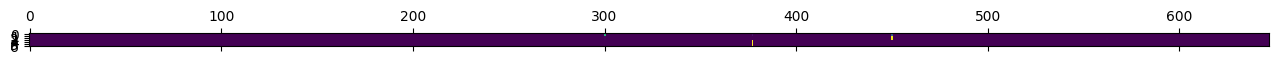

In [76]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [77]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

In [78]:
dataset[2][0]

tensor([[ 9],
        [10],
        [15],
        [14],
        [ 1]])

input = 보통 요즘 현대인 들 이 많이 키우는 반려동물 은 개 고양이 위주 로 많이 키우는데 그 외 에도 요즘 에 이 이색 적 이 게 침팬지 햄스터 혹은 작은 미니 피그 같은 동물 도 많이 키우고 있 있다고 들었습니다 . <EOS>
output = 그래서 그 에 에 이 이 이 <EOS>


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

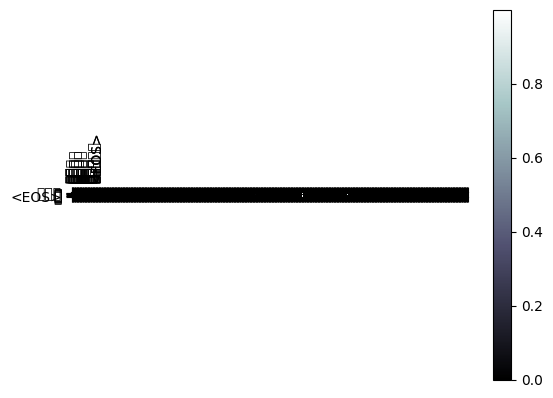

In [79]:
evaluate_and_show_attention(encoder, decoder, dataset[2][1], dataset, device)